# Model Experimentation Tracking (MLFow) - Hyperparamter Optimization

Record and query experiments: Code, data, config, results, parameters, metrics

![Data](images/MLflow_Model_experimentation.png)

## Import Packages

In [3]:
# Data analysis library
import numpy as np
import pandas as pd
import joblib

# Machine Learning library
import sklearn
from sklearn.metrics import roc_curve, auc, accuracy_score, plot_confusion_matrix, plot_roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import plot_importance, plot_metric

# Model experimentation library
import mlflow
import mlflow.lightgbm
from mlflow.tracking import MlflowClient

# Hyperparameter tunning library
import optuna

# Plotting library
import matplotlib.pyplot as plt
# Prevent figures from displaying by turning interactive mode off using the function
plt.ioff()
import warnings
warnings.filterwarnings("ignore")

In [4]:
print(f'Numpy version is {np.__version__}')
print(f'Pandas version is {pd.__version__}')
print(f'sklearn version is {sklearn.__version__}')
print(f'mlflow version is {mlflow.__version__}')
print(f'joblib version is {joblib.__version__}')
print(f'optuna version is {optuna.__version__}')

Numpy version is 1.22.4
Pandas version is 1.5.3
sklearn version is 1.1.2
mlflow version is 2.3.2
joblib version is 1.3.1
optuna version is 3.3.0


## Load data

In [5]:
## Files
data_file='/mnt/data/Heart-Attack-prediction/heart.csv'

# Load train loan dataset 
try:
    data = pd.read_csv(data_file)
    print("The dataset has {} samples with {} features.".format(*data.shape))
except:
    print("The dataset could not be loaded. Is the dataset missing?")
    


The dataset has 303 samples with 14 features.


## Introduction To The Data

In [6]:
data.head()

age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1

In [7]:
data['output'].value_counts()

1    165
0    138
Name: output, dtype: int64

## Initialize MLflow

**Experiments** : You can organize runs into experiments, which group together runs for a specific task. 

**Tracking URI**: MLflow runs can be recorded to local files, to a database, or remotely to a tracking server. By default, the MLflow Python API logs runs locally to files in an mlruns directory wherever you ran your program

#### MLflow Tracking Servers 
MLflow tracking server has two components for storage: a **backend store** and an **artifact store**

The **backend store** is where MLflow Tracking Server stores experiment and run metadata as well as params, metrics, and tags for runs. MLflow supports two types of backend stores: **file store and database-backed store**.

The **artifact store** is a location suitable for large data (such as an S3 bucket or shared NFS file system) and is where clients log their artifact output (for example, models).

    Amazon S3 and S3-compatible storage
    Azure Blob Storage
    Google Cloud Storage
    FTP server
    SFTP Server
    NFS
    HDFS

In [8]:
experiment_name = "heart_attack_predictions_v2"

# Initialize client
client = MlflowClient()

# If experiment doesn't exist then it will create new
# else it will take the experiment id and will use to to run the experiments
try:
    # Create experiment 
    experiment_id = client.create_experiment(experiment_name)
except:
    # Get the experiment id if it already exists
    experiment_id = client.get_experiment_by_name(experiment_name).experiment_id

## Prepare data for model training

In [10]:
exclude_feature = []
# Define Target columns
target = data['output']

# Define numeric and categorical features
numeric_features = [ 'age', 'trtbps', 'chol', 'thalachh', 'oldpeak' ]
categorical_features = [ 'sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall' ]


# Define final feature list for training and validation
features = numeric_features + categorical_features
# Final data for training and validation
data = data[features]
data = data.fillna(0)

# Split data in train and vlaidation
X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size=0.15, random_state=10)

# Perform label encoding for categorical variable
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(X_train.loc[:, feature])
    X_train.loc[:, feature] = le.transform(X_train.loc[:, feature])
    X_valid.loc[:, feature] = le.transform(X_valid.loc[:, feature])

## Lightgbm Hyperparameter tunning + MLFlow for model tracking

### Define model training function to train and track model results

In [11]:
def model_training_tracking(params):
    # Launching Multiple Runs in One Program.This is easy to do because the ActiveRun object returned by mlflow.start_run() is a 
    # Python context manager. You can “scope” each run to just one block of code as follows:
    with mlflow.start_run(experiment_id=experiment_id, run_name='Lightgbm_model') as run:
        # Get run id 
        run_id = run.info.run_uuid
        
        # Set the notes for the run
        MlflowClient().set_tag(run_id,
                               "mlflow.note.content",
                               "This is experiment for hyperparameter optimzation for lightgbm models for the Campus Recruitment Dataset")
        
        # Define customer tag
        tags = {"Application": "Payment Monitoring Platform",
                "release.candidate": "PMP",
                "release.version": "2.2.0"}

        # Set Tag
        mlflow.set_tags(tags)
                        
        # Log python environment details
        mlflow.log_artifact('requirements.txt')
        
        # logging params
        mlflow.log_params(params)

        # Perform model training
        lgb_clf = LGBMClassifier(**params)
        lgb_clf.fit(X_train, y_train, 
                    eval_set = [(X_train, y_train), (X_valid, y_valid)], 
                    early_stopping_rounds=50,
                    verbose=20)

        # Log model artifacts
        mlflow.sklearn.log_model(lgb_clf, "model")

        # Perform model evaluation 
        lgb_valid_prediction = lgb_clf.predict_proba(X_valid)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_valid, lgb_valid_prediction)
        roc_auc = auc(fpr, tpr) # compute area under the curve
        print("=====================================")
        print("Validation AUC:{}".format(roc_auc))
        print("=====================================")   

        # log metrics
        mlflow.log_metrics({"Validation_AUC": roc_auc})

        # Plot and save feature importance details
        ax = plot_importance(lgb_clf, height=0.4)
        filename = './images/lgb_validation_feature_importance.png'
        plt.savefig(filename)
        # log model artifacts
        mlflow.log_artifact(filename)

        ax = plot_metric(lgb_clf.evals_result_)
        filename = './images/lgb_validation_metrics_comparision.png'
        plt.savefig(filename)
        # log model artifacts
        mlflow.log_artifact(filename)

        # Plot and save metrics details    
        plot_confusion_matrix(lgb_clf, X_valid, y_valid, 
                              display_labels=['Placed', 'Not Placed'],
                              cmap='magma')
        plt.title('Confusion Matrix')
        filename = './images/lgb_validation_confusion_matrix.png'
        plt.savefig(filename)
        # log model artifacts
        mlflow.log_artifact(filename)

        # Plot and save AUC details  
        plot_roc_curve(lgb_clf, X_valid, y_valid, name='Validation')
        plt.title('ROC AUC Curve')
        filename = './images/lgb_validation_roc_curve.png'
        plt.savefig(filename)
        # log model artifacts
        mlflow.log_artifact(filename)
        
        return roc_auc

### Define an objective function to be maximized

In [12]:
def objective(trial):

    param = {
        "objective": "binary",
        "metric": "auc",
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 1e-1, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "random_state": 42,
    }
    
    auc = model_training_tracking(param)
    return auc

### Create a study object and optimize the objective function

[I 2023-10-16 19:07:35,550] A new study created in memory with name: no-name-08236bcb-cac1-4f6a-a2e8-600fdab3b34e


[20]	training's auc: 0.960416	valid_1's auc: 0.925926
[40]	training's auc: 0.9689	valid_1's auc: 0.923977
[60]	training's auc: 0.975441	valid_1's auc: 0.923977
Validation AUC:0.9376218323586745


[I 2023-10-16 19:07:42,267] Trial 0 finished with value: 0.9376218323586745 and parameters: {'learning_rate': 0.033144161435846885, 'colsample_bytree': 0.6544287073255983, 'subsample': 0.6457769367894827}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.955449	valid_1's auc: 0.935673
[40]	training's auc: 0.964211	valid_1's auc: 0.927875
[60]	training's auc: 0.972356	valid_1's auc: 0.920078
Validation AUC:0.9356725146198831


[I 2023-10-16 19:07:49,415] Trial 1 finished with value: 0.9356725146198831 and parameters: {'learning_rate': 0.025980801798863428, 'colsample_bytree': 0.6261807634203763, 'subsample': 0.975205682109107}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.951068	valid_1's auc: 0.925926
[40]	training's auc: 0.95767	valid_1's auc: 0.918129
Validation AUC:0.9288499025341131


[I 2023-10-16 19:07:56,019] Trial 2 finished with value: 0.9288499025341131 and parameters: {'learning_rate': 0.017232763658729593, 'colsample_bytree': 0.5249765426994755, 'subsample': 0.4941965316703978}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.950574	valid_1's auc: 0.91423
[40]	training's auc: 0.961989	valid_1's auc: 0.925926
[60]	training's auc: 0.969394	valid_1's auc: 0.929825
[80]	training's auc: 0.975071	valid_1's auc: 0.937622
[100]	training's auc: 0.978958	valid_1's auc: 0.933723
Validation AUC:0.9337231968810916


[I 2023-10-16 19:08:02,846] Trial 3 finished with value: 0.9337231968810916 and parameters: {'learning_rate': 0.024117919807940646, 'colsample_bytree': 0.4566468283306181, 'subsample': 0.7051856550957276}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.958904	valid_1's auc: 0.916179
[40]	training's auc: 0.975379	valid_1's auc: 0.91423
[60]	training's auc: 0.986672	valid_1's auc: 0.91423
[80]	training's auc: 0.993768	valid_1's auc: 0.908382
Validation AUC:0.9200779727095517


[I 2023-10-16 19:08:09,979] Trial 4 finished with value: 0.9200779727095517 and parameters: {'learning_rate': 0.048197015525449506, 'colsample_bytree': 0.9959128505749895, 'subsample': 0.7995096077219894}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.966679	valid_1's auc: 0.920078
[40]	training's auc: 0.98661	valid_1's auc: 0.925926
[60]	training's auc: 0.994015	valid_1's auc: 0.916179
[80]	training's auc: 0.998272	valid_1's auc: 0.906433
Validation AUC:0.9298245614035088


[I 2023-10-16 19:08:17,281] Trial 5 finished with value: 0.9298245614035088 and parameters: {'learning_rate': 0.07227936682420713, 'colsample_bytree': 0.6488327281952967, 'subsample': 0.7577464706155623}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.950882	valid_1's auc: 0.925926
[40]	training's auc: 0.956806	valid_1's auc: 0.918129
Validation AUC:0.9288499025341131


[I 2023-10-16 19:08:24,019] Trial 6 finished with value: 0.9288499025341131 and parameters: {'learning_rate': 0.01617051949234208, 'colsample_bytree': 0.5604696113140245, 'subsample': 0.416117654137172}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.948136	valid_1's auc: 0.911306
[40]	training's auc: 0.963223	valid_1's auc: 0.923977
[60]	training's auc: 0.974145	valid_1's auc: 0.925926
[80]	training's auc: 0.982105	valid_1's auc: 0.918129
[100]	training's auc: 0.989202	valid_1's auc: 0.918129
Validation AUC:0.9181286549707602


[I 2023-10-16 19:08:30,798] Trial 7 finished with value: 0.9181286549707602 and parameters: {'learning_rate': 0.031975869679208575, 'colsample_bytree': 0.9729978436368926, 'subsample': 0.843788979517327}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.939529	valid_1's auc: 0.89961
[40]	training's auc: 0.945329	valid_1's auc: 0.917154
[60]	training's auc: 0.951623	valid_1's auc: 0.916179
[80]	training's auc: 0.958225	valid_1's auc: 0.923977
[100]	training's auc: 0.962051	valid_1's auc: 0.920078
Validation AUC:0.9200779727095517


[I 2023-10-16 19:08:37,651] Trial 8 finished with value: 0.9200779727095517 and parameters: {'learning_rate': 0.011227256959059653, 'colsample_bytree': 0.9154167748323809, 'subsample': 0.4907817334983757}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.957732	valid_1's auc: 0.918129
[40]	training's auc: 0.972911	valid_1's auc: 0.925926
[60]	training's auc: 0.982105	valid_1's auc: 0.927875
[80]	training's auc: 0.989387	valid_1's auc: 0.923977
Validation AUC:0.9337231968810917


[I 2023-10-16 19:08:44,449] Trial 9 finished with value: 0.9337231968810917 and parameters: {'learning_rate': 0.04720478173943752, 'colsample_bytree': 0.4439825848136752, 'subsample': 0.8603817460306102}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.97686	valid_1's auc: 0.927875
[40]	training's auc: 0.993829	valid_1's auc: 0.912281
[60]	training's auc: 0.998519	valid_1's auc: 0.906433
Validation AUC:0.9317738791423003


[I 2023-10-16 19:08:51,210] Trial 10 finished with value: 0.9317738791423003 and parameters: {'learning_rate': 0.0973657095412732, 'colsample_bytree': 0.777930508246945, 'subsample': 0.5986219149143932}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.959058	valid_1's auc: 0.931774
[40]	training's auc: 0.967975	valid_1's auc: 0.929825
[60]	training's auc: 0.97433	valid_1's auc: 0.923977
Validation AUC:0.9337231968810916


[I 2023-10-16 19:08:57,894] Trial 11 finished with value: 0.9337231968810916 and parameters: {'learning_rate': 0.030003483609612733, 'colsample_bytree': 0.6883599910466499, 'subsample': 0.9464975556056242}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.956683	valid_1's auc: 0.933723
[40]	training's auc: 0.968715	valid_1's auc: 0.927875
[60]	training's auc: 0.976922	valid_1's auc: 0.922027
Validation AUC:0.9337231968810916


[I 2023-10-16 19:09:04,665] Trial 12 finished with value: 0.9337231968810916 and parameters: {'learning_rate': 0.034624003894879664, 'colsample_bytree': 0.6132283288080423, 'subsample': 0.9454077362239296}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.952579	valid_1's auc: 0.906433
[40]	training's auc: 0.962637	valid_1's auc: 0.91423
[60]	training's auc: 0.967358	valid_1's auc: 0.91423
Validation AUC:0.9239766081871346


[I 2023-10-16 19:09:11,820] Trial 13 finished with value: 0.9239766081871346 and parameters: {'learning_rate': 0.02275427481283754, 'colsample_bytree': 0.752285751947125, 'subsample': 0.6544893608596482}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.960292	valid_1's auc: 0.923977
[40]	training's auc: 0.972294	valid_1's auc: 0.929825
[60]	training's auc: 0.985314	valid_1's auc: 0.923977
[80]	training's auc: 0.992102	valid_1's auc: 0.922027
Validation AUC:0.9298245614035088


[I 2023-10-16 19:09:18,917] Trial 14 finished with value: 0.9298245614035088 and parameters: {'learning_rate': 0.0433758491180419, 'colsample_bytree': 0.5876657829631948, 'subsample': 0.9826872817676351}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.954739	valid_1's auc: 0.927875
[40]	training's auc: 0.964149	valid_1's auc: 0.929825
[60]	training's auc: 0.969764	valid_1's auc: 0.923977
Validation AUC:0.935672514619883


[I 2023-10-16 19:09:25,741] Trial 15 finished with value: 0.935672514619883 and parameters: {'learning_rate': 0.02366239931887182, 'colsample_bytree': 0.7244703550790785, 'subsample': 0.6412856048754463}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.963563	valid_1's auc: 0.927875
[40]	training's auc: 0.970998	valid_1's auc: 0.925926
[60]	training's auc: 0.979699	valid_1's auc: 0.931774
Validation AUC:0.9376218323586745


[I 2023-10-16 19:09:32,818] Trial 16 finished with value: 0.9376218323586745 and parameters: {'learning_rate': 0.038657862135273106, 'colsample_bytree': 0.6639777683620475, 'subsample': 0.7371374390148755}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.964859	valid_1's auc: 0.918129
[40]	training's auc: 0.980563	valid_1's auc: 0.922027
[60]	training's auc: 0.990682	valid_1's auc: 0.906433
[80]	training's auc: 0.996976	valid_1's auc: 0.896686
Validation AUC:0.9220272904483431


[I 2023-10-16 19:09:39,723] Trial 17 finished with value: 0.9220272904483431 and parameters: {'learning_rate': 0.0587761988825732, 'colsample_bytree': 0.8228292537354593, 'subsample': 0.7303973071396621}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.963501	valid_1's auc: 0.927875
[40]	training's auc: 0.971184	valid_1's auc: 0.920078
[60]	training's auc: 0.980131	valid_1's auc: 0.91423
Validation AUC:0.9376218323586745


[I 2023-10-16 19:09:46,446] Trial 18 finished with value: 0.9376218323586745 and parameters: {'learning_rate': 0.03821499238751558, 'colsample_bytree': 0.6786158167051338, 'subsample': 0.6120598872407232}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.964057	valid_1's auc: 0.920078
[40]	training's auc: 0.981735	valid_1's auc: 0.922027
[60]	training's auc: 0.990806	valid_1's auc: 0.910331
[80]	training's auc: 0.996483	valid_1's auc: 0.902534
Validation AUC:0.9259259259259259


[I 2023-10-16 19:09:53,450] Trial 19 finished with value: 0.9259259259259259 and parameters: {'learning_rate': 0.056895631137794105, 'colsample_bytree': 0.8152247130558492, 'subsample': 0.6951711256314315}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.958719	valid_1's auc: 0.923977
[40]	training's auc: 0.969949	valid_1's auc: 0.922027
[60]	training's auc: 0.979699	valid_1's auc: 0.925926
Validation AUC:0.9346978557504874


[I 2023-10-16 19:10:00,342] Trial 20 finished with value: 0.9346978557504874 and parameters: {'learning_rate': 0.03886980442398027, 'colsample_bytree': 0.5332870179336822, 'subsample': 0.7679295195880756}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.963501	valid_1's auc: 0.927875
[40]	training's auc: 0.970073	valid_1's auc: 0.923977
[60]	training's auc: 0.979452	valid_1's auc: 0.922027
Validation AUC:0.9376218323586745


[I 2023-10-16 19:10:07,185] Trial 21 finished with value: 0.9376218323586745 and parameters: {'learning_rate': 0.03888192526252291, 'colsample_bytree': 0.6784549893344772, 'subsample': 0.579948935417116}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.960046	valid_1's auc: 0.929825
[40]	training's auc: 0.968962	valid_1's auc: 0.923977
[60]	training's auc: 0.976922	valid_1's auc: 0.922027
Validation AUC:0.9376218323586745


[I 2023-10-16 19:10:14,014] Trial 22 finished with value: 0.9376218323586745 and parameters: {'learning_rate': 0.03371681032431852, 'colsample_bytree': 0.680012007865526, 'subsample': 0.6743407711016424}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.956189	valid_1's auc: 0.933723
[40]	training's auc: 0.967111	valid_1's auc: 0.923977
[60]	training's auc: 0.974454	valid_1's auc: 0.922027
Validation AUC:0.9337231968810916


[I 2023-10-16 19:10:21,101] Trial 23 finished with value: 0.9337231968810916 and parameters: {'learning_rate': 0.029471687611151855, 'colsample_bytree': 0.6195480213461699, 'subsample': 0.6282701895079845}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.960601	valid_1's auc: 0.929825
[40]	training's auc: 0.971245	valid_1's auc: 0.922027
[60]	training's auc: 0.97865	valid_1's auc: 0.918129
Validation AUC:0.9376218323586745


[I 2023-10-16 19:10:27,962] Trial 24 finished with value: 0.9376218323586745 and parameters: {'learning_rate': 0.037087496475954586, 'colsample_bytree': 0.7152888812487723, 'subsample': 0.5868692548727955}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.965044	valid_1's auc: 0.923977
[40]	training's auc: 0.975441	valid_1's auc: 0.925926
[60]	training's auc: 0.985931	valid_1's auc: 0.925926
Validation AUC:0.9376218323586745


[I 2023-10-16 19:10:35,255] Trial 25 finished with value: 0.9376218323586745 and parameters: {'learning_rate': 0.04816066219962736, 'colsample_bytree': 0.6687569079462494, 'subsample': 0.7190083317543193}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.958904	valid_1's auc: 0.923977
[40]	training's auc: 0.970135	valid_1's auc: 0.922027
[60]	training's auc: 0.980069	valid_1's auc: 0.927875
Validation AUC:0.9346978557504874


[I 2023-10-16 19:10:42,176] Trial 26 finished with value: 0.9346978557504874 and parameters: {'learning_rate': 0.03962355654144237, 'colsample_bytree': 0.5721107385299338, 'subsample': 0.6720331363621407}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.955634	valid_1's auc: 0.935673
[40]	training's auc: 0.965692	valid_1's auc: 0.925926
[60]	training's auc: 0.973096	valid_1's auc: 0.922027
Validation AUC:0.9356725146198831


[I 2023-10-16 19:10:48,978] Trial 27 finished with value: 0.9356725146198831 and parameters: {'learning_rate': 0.027763157564358647, 'colsample_bytree': 0.6469210092088387, 'subsample': 0.5603326549768594}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.960046	valid_1's auc: 0.929825
[40]	training's auc: 0.968962	valid_1's auc: 0.923977
[60]	training's auc: 0.976922	valid_1's auc: 0.922027
Validation AUC:0.9376218323586745


[I 2023-10-16 19:10:56,718] Trial 28 finished with value: 0.9376218323586745 and parameters: {'learning_rate': 0.03362173551854989, 'colsample_bytree': 0.7258845359207329, 'subsample': 0.6265965198096001}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.955572	valid_1's auc: 0.935673
[40]	training's auc: 0.965321	valid_1's auc: 0.927875
[60]	training's auc: 0.972479	valid_1's auc: 0.920078
Validation AUC:0.9356725146198831


[I 2023-10-16 19:11:03,646] Trial 29 finished with value: 0.9356725146198831 and parameters: {'learning_rate': 0.026977805293404943, 'colsample_bytree': 0.6320149497315162, 'subsample': 0.6849093750328391}. Best is trial 0 with value: 0.9376218323586745.


[20]	training's auc: 0.964612	valid_1's auc: 0.918129
[40]	training's auc: 0.978341	valid_1's auc: 0.933723
[60]	training's auc: 0.988708	valid_1's auc: 0.927875
[80]	training's auc: 0.995125	valid_1's auc: 0.918129
Validation AUC:0.9415204678362573


[I 2023-10-16 19:11:10,841] Trial 30 finished with value: 0.9415204678362573 and parameters: {'learning_rate': 0.055268784686599834, 'colsample_bytree': 0.6045497868235816, 'subsample': 0.5405348111505418}. Best is trial 30 with value: 0.9415204678362573.


[20]	training's auc: 0.964797	valid_1's auc: 0.918129
[40]	training's auc: 0.978588	valid_1's auc: 0.931774
[60]	training's auc: 0.989942	valid_1's auc: 0.929825
[80]	training's auc: 0.995681	valid_1's auc: 0.923977
Validation AUC:0.935672514619883


[I 2023-10-16 19:11:17,930] Trial 31 finished with value: 0.935672514619883 and parameters: {'learning_rate': 0.056862302940864376, 'colsample_bytree': 0.6080450029164539, 'subsample': 0.536689816905962}. Best is trial 30 with value: 0.9415204678362573.


[20]	training's auc: 0.959891	valid_1's auc: 0.922027
[40]	training's auc: 0.970443	valid_1's auc: 0.922027
[60]	training's auc: 0.98155	valid_1's auc: 0.929825
Validation AUC:0.9346978557504874


[I 2023-10-16 19:11:24,638] Trial 32 finished with value: 0.9346978557504874 and parameters: {'learning_rate': 0.04232994508418805, 'colsample_bytree': 0.5015791507364146, 'subsample': 0.619594057651162}. Best is trial 30 with value: 0.9415204678362573.


[20]	training's auc: 0.962205	valid_1's auc: 0.920078
[40]	training's auc: 0.975133	valid_1's auc: 0.922027
[60]	training's auc: 0.98735	valid_1's auc: 0.925926
[80]	training's auc: 0.993706	valid_1's auc: 0.920078
Validation AUC:0.9298245614035088


[I 2023-10-16 19:11:31,501] Trial 33 finished with value: 0.9298245614035088 and parameters: {'learning_rate': 0.049606996351153225, 'colsample_bytree': 0.5866641594289683, 'subsample': 0.5331049279762274}. Best is trial 30 with value: 0.9415204678362573.


[20]	training's auc: 0.965692	valid_1's auc: 0.920078
[40]	training's auc: 0.985623	valid_1's auc: 0.927875
[60]	training's auc: 0.993891	valid_1's auc: 0.923977
[80]	training's auc: 0.997408	valid_1's auc: 0.920078
Validation AUC:0.9317738791423003


[I 2023-10-16 19:11:38,616] Trial 34 finished with value: 0.9317738791423003 and parameters: {'learning_rate': 0.06624559064142235, 'colsample_bytree': 0.6415053400545399, 'subsample': 0.66431219693976}. Best is trial 30 with value: 0.9415204678362573.


[20]	training's auc: 0.96273	valid_1's auc: 0.918129
[40]	training's auc: 0.97069	valid_1's auc: 0.916179
[60]	training's auc: 0.979514	valid_1's auc: 0.920078
Validation AUC:0.9259259259259259


[I 2023-10-16 19:11:45,238] Trial 35 finished with value: 0.9259259259259259 and parameters: {'learning_rate': 0.04331299556047325, 'colsample_bytree': 0.4105610968049468, 'subsample': 0.6089353907347818}. Best is trial 30 with value: 0.9415204678362573.


[20]	training's auc: 0.960292	valid_1's auc: 0.929825
[40]	training's auc: 0.969394	valid_1's auc: 0.922027
[60]	training's auc: 0.977539	valid_1's auc: 0.925926
Validation AUC:0.9376218323586745


[I 2023-10-16 19:11:52,464] Trial 36 finished with value: 0.9376218323586745 and parameters: {'learning_rate': 0.03487237317539121, 'colsample_bytree': 0.6673696922209446, 'subsample': 0.4942154157329694}. Best is trial 30 with value: 0.9415204678362573.


[20]	training's auc: 0.956127	valid_1's auc: 0.929825
[40]	training's auc: 0.961989	valid_1's auc: 0.923977
[60]	training's auc: 0.969703	valid_1's auc: 0.937622
[80]	training's auc: 0.974762	valid_1's auc: 0.935673
[100]	training's auc: 0.980131	valid_1's auc: 0.929825
Validation AUC:0.9298245614035088


[I 2023-10-16 19:11:59,367] Trial 37 finished with value: 0.9298245614035088 and parameters: {'learning_rate': 0.024877000060759262, 'colsample_bytree': 0.5272014779353285, 'subsample': 0.7244905301413479}. Best is trial 30 with value: 0.9415204678362573.


[20]	training's auc: 0.956374	valid_1's auc: 0.933723
[40]	training's auc: 0.967666	valid_1's auc: 0.925926
[60]	training's auc: 0.975256	valid_1's auc: 0.920078
Validation AUC:0.9337231968810916


[I 2023-10-16 19:12:06,309] Trial 38 finished with value: 0.9337231968810916 and parameters: {'learning_rate': 0.03083681297289226, 'colsample_bytree': 0.6019602182684803, 'subsample': 0.5689248341847923}. Best is trial 30 with value: 0.9415204678362573.


[20]	training's auc: 0.954338	valid_1's auc: 0.925926
[40]	training's auc: 0.959891	valid_1's auc: 0.922027
[60]	training's auc: 0.967605	valid_1's auc: 0.933723
[80]	training's auc: 0.97322	valid_1's auc: 0.931774
[100]	training's auc: 0.976614	valid_1's auc: 0.929825
Validation AUC:0.9298245614035088


[I 2023-10-16 19:12:13,338] Trial 39 finished with value: 0.9298245614035088 and parameters: {'learning_rate': 0.02081448472652658, 'colsample_bytree': 0.5708831206765652, 'subsample': 0.6352061498489079}. Best is trial 30 with value: 0.9415204678362573.


AUC: 0.9415204678362573
Best hyperparameters: {'learning_rate': 0.055268784686599834, 'colsample_bytree': 0.6045497868235816, 'subsample': 0.5405348111505418}


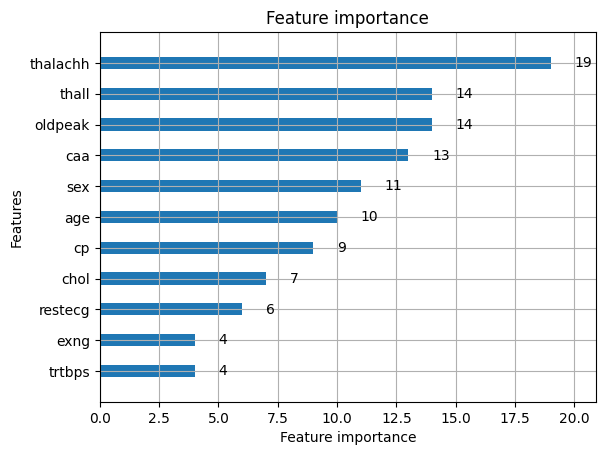

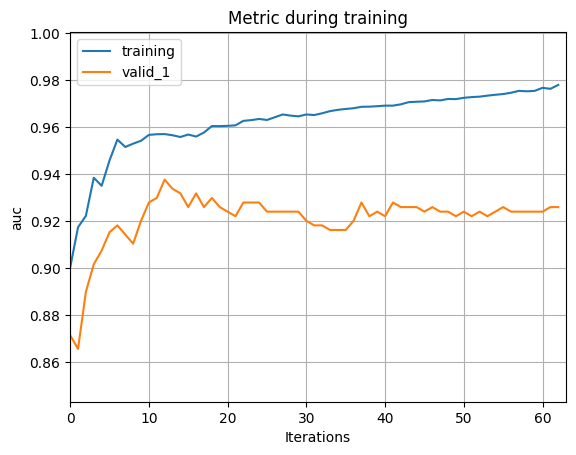

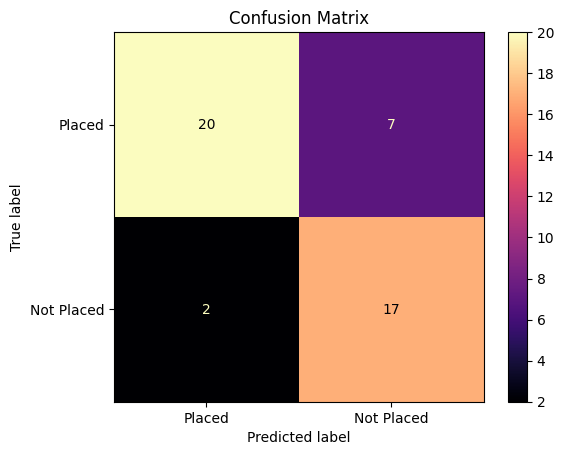

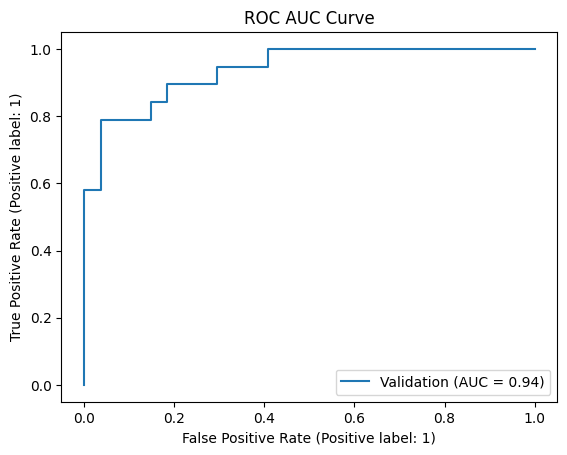

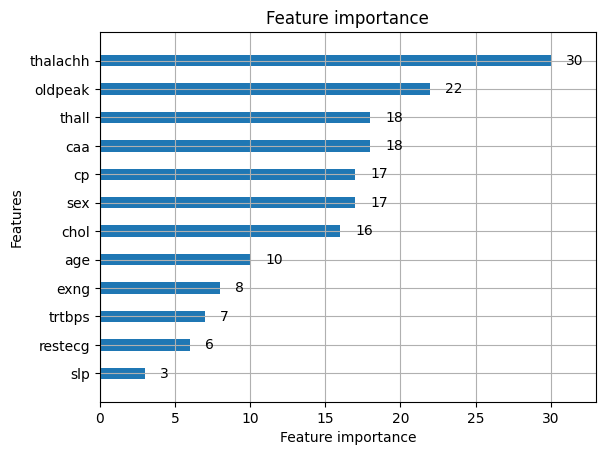

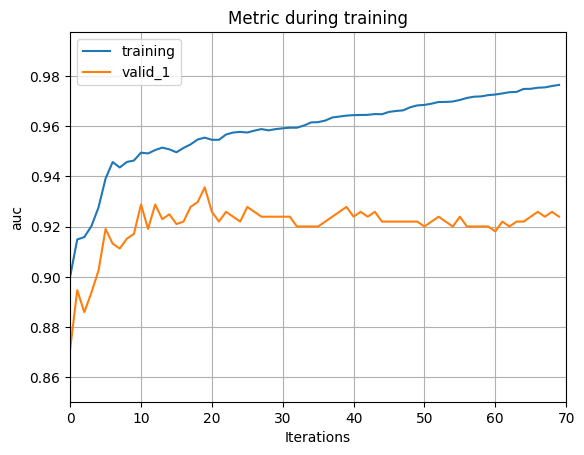

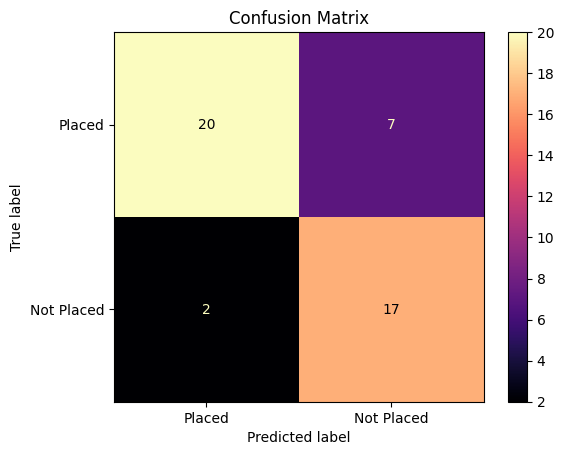

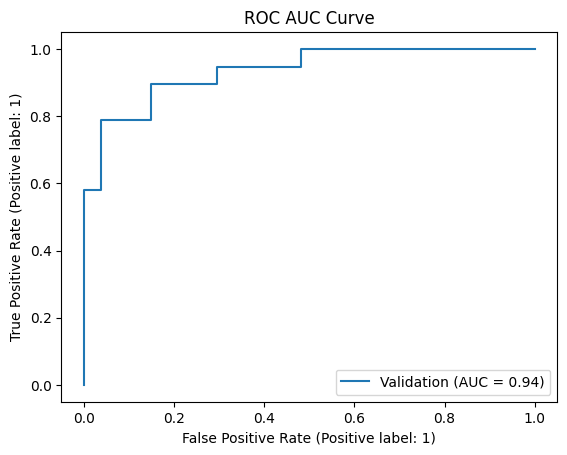

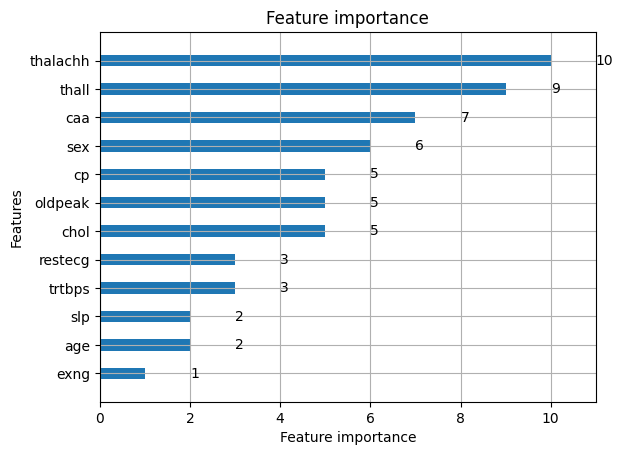

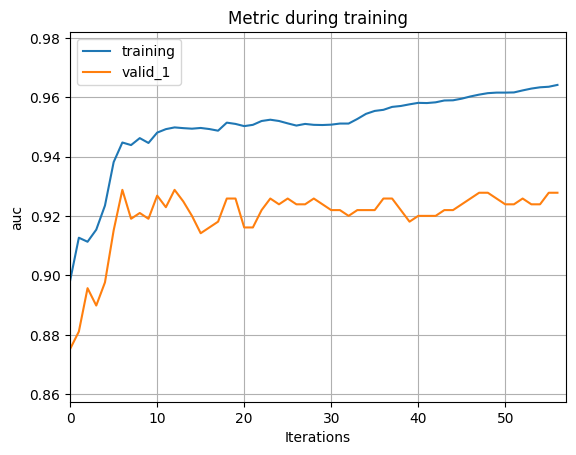

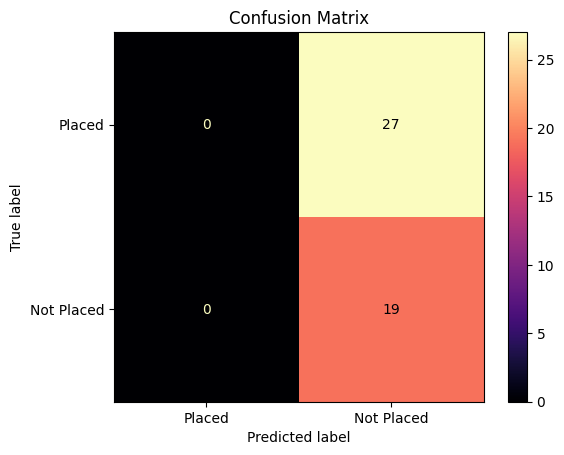

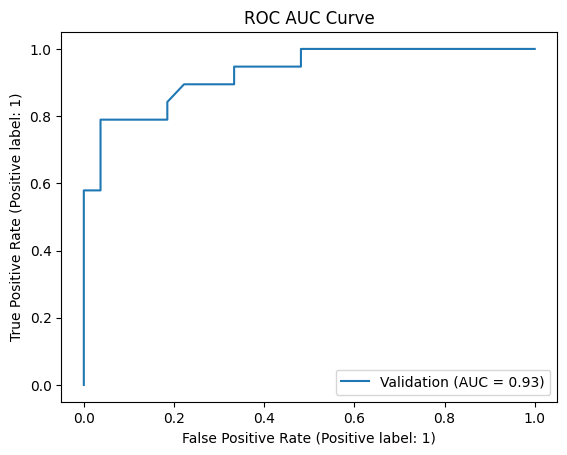

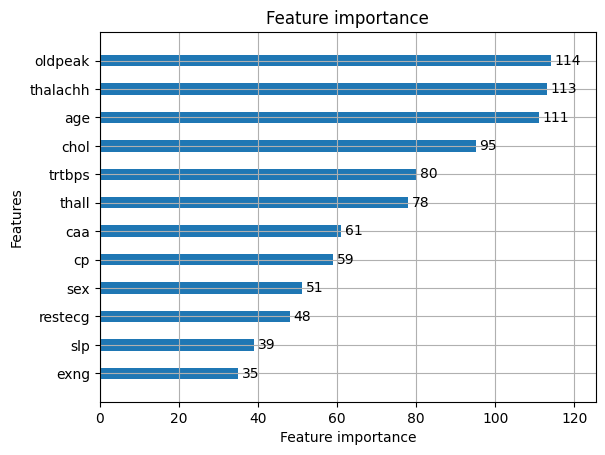

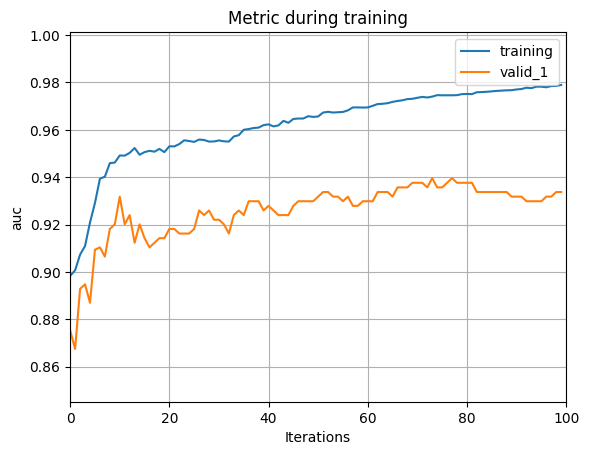

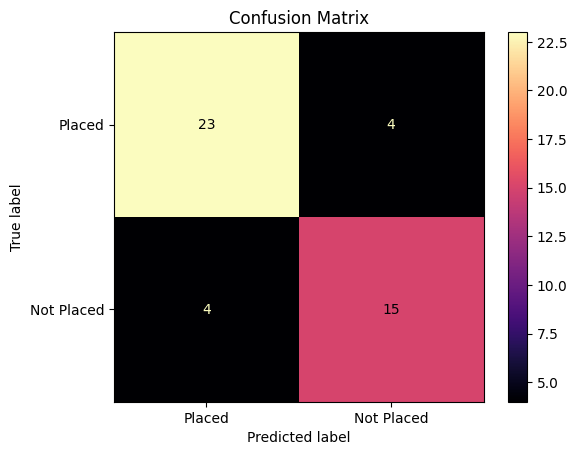

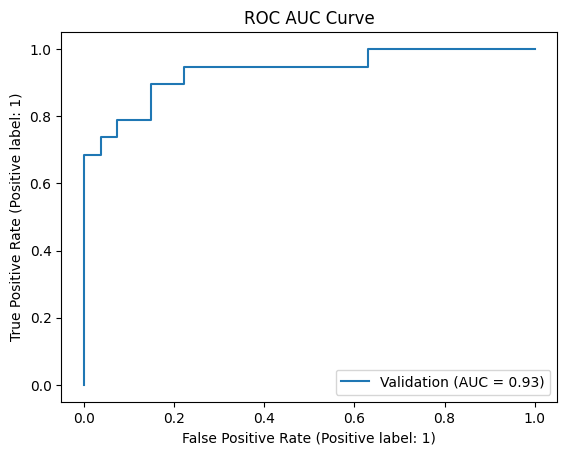

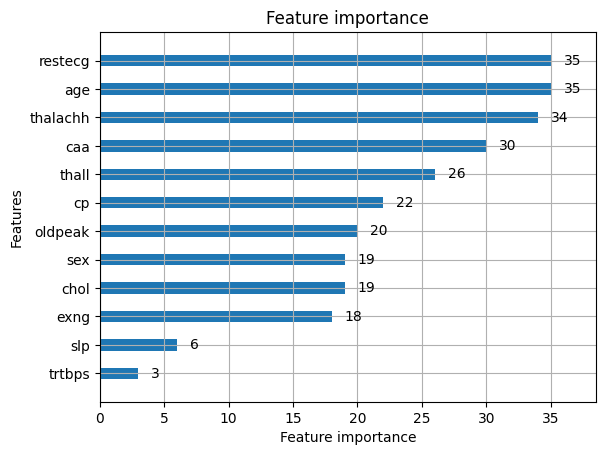

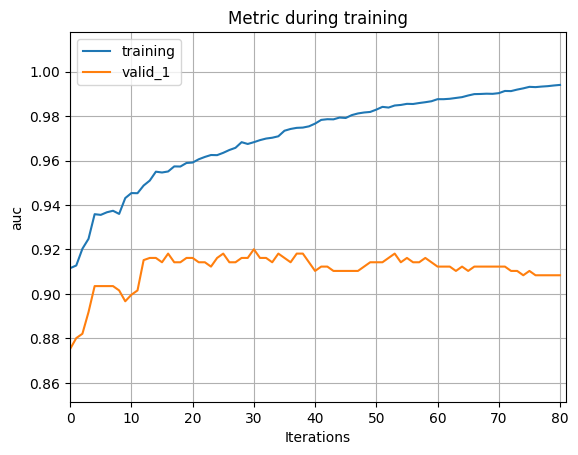

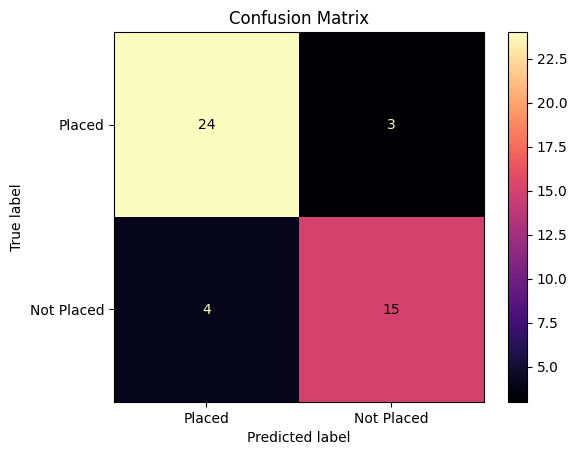

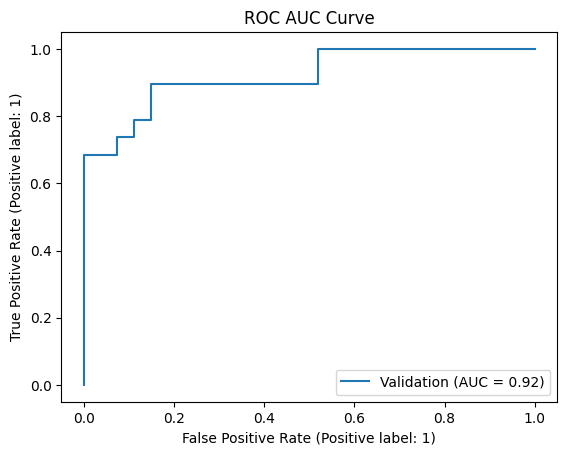

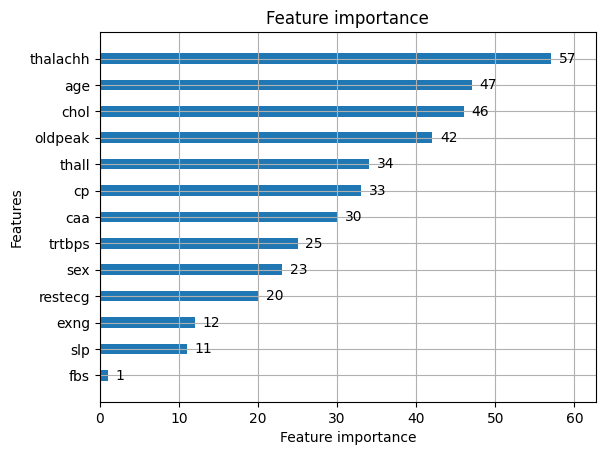

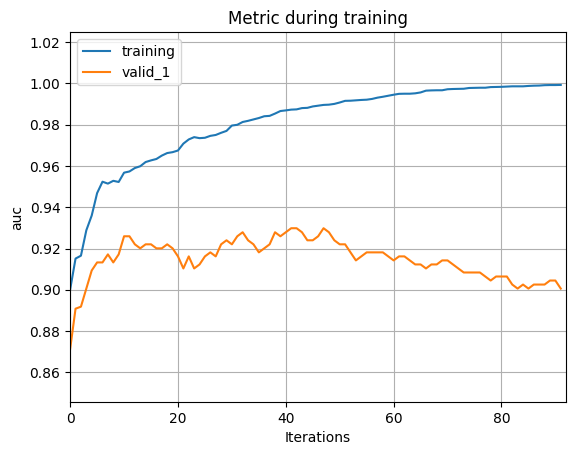

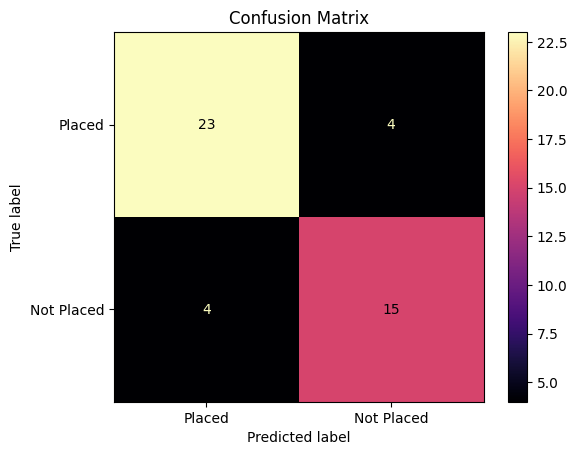

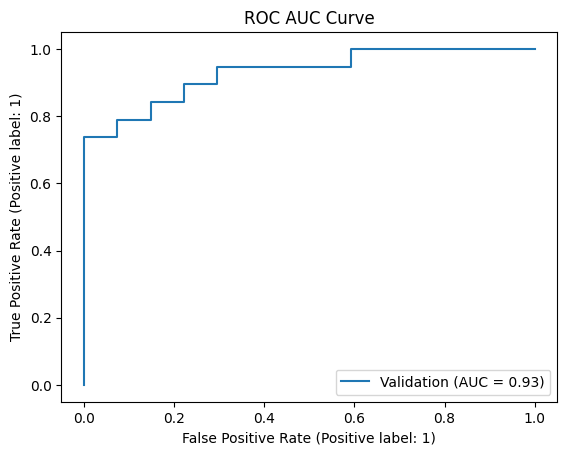

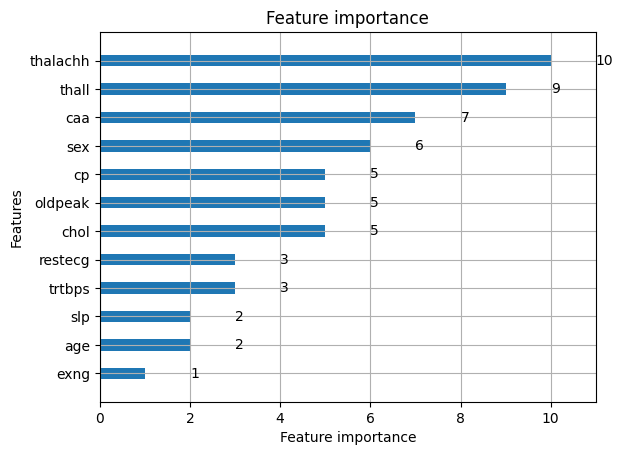

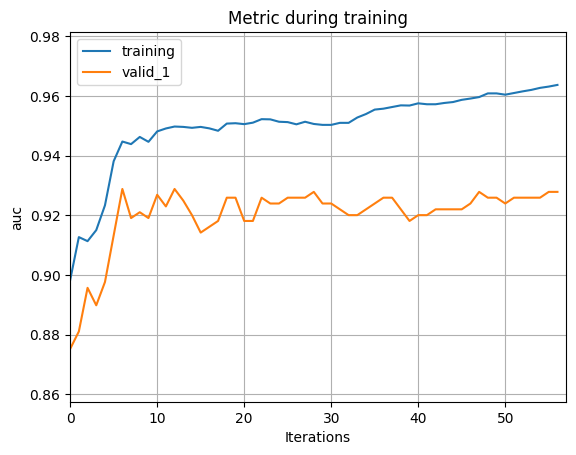

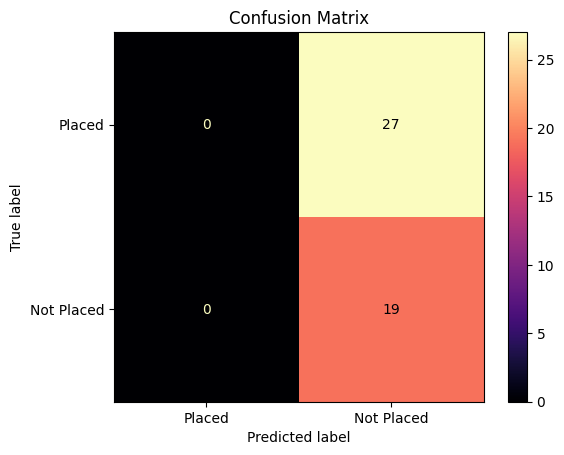

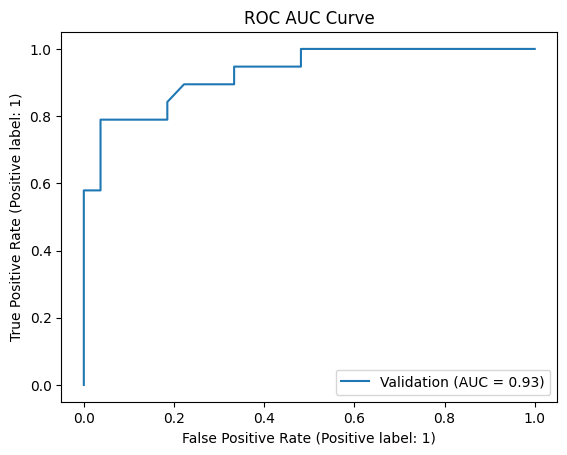

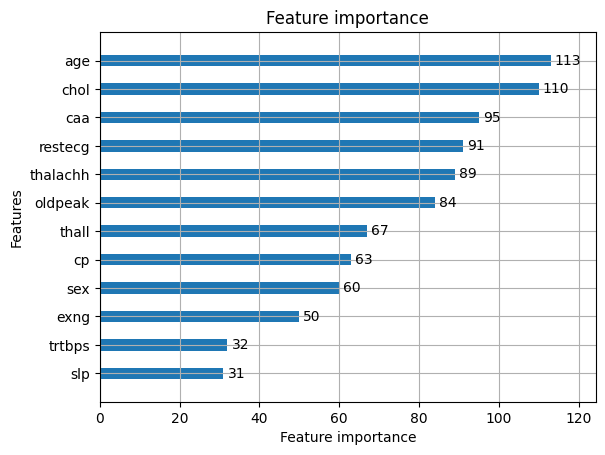

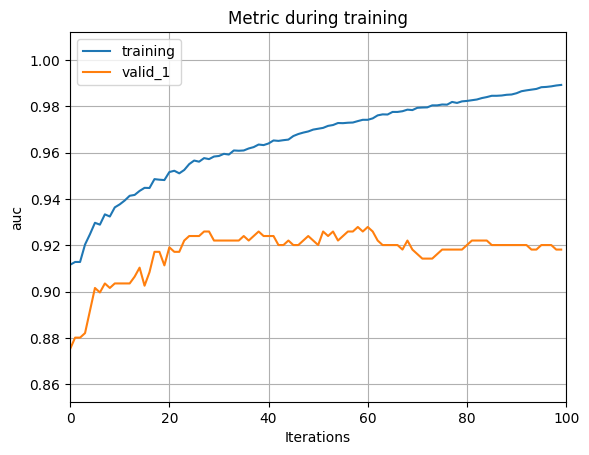

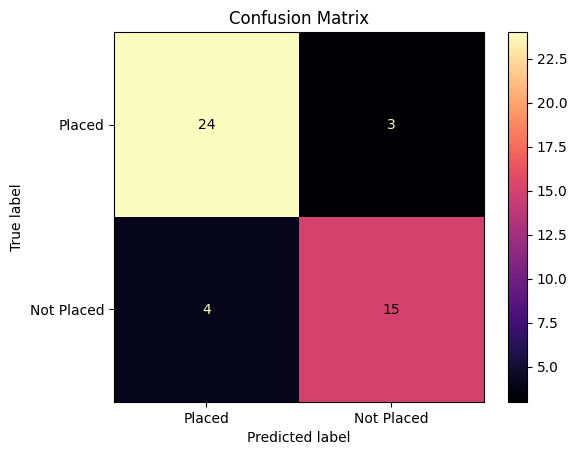

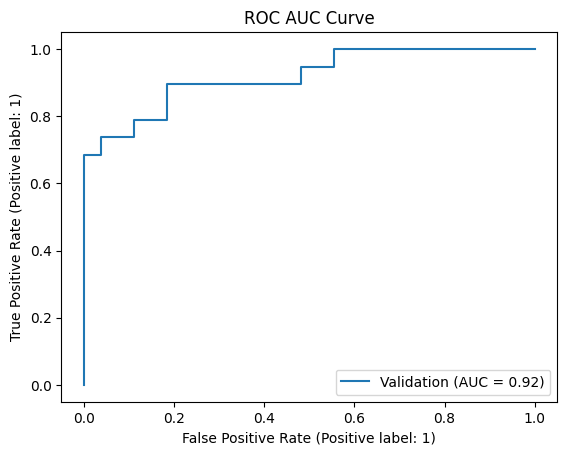

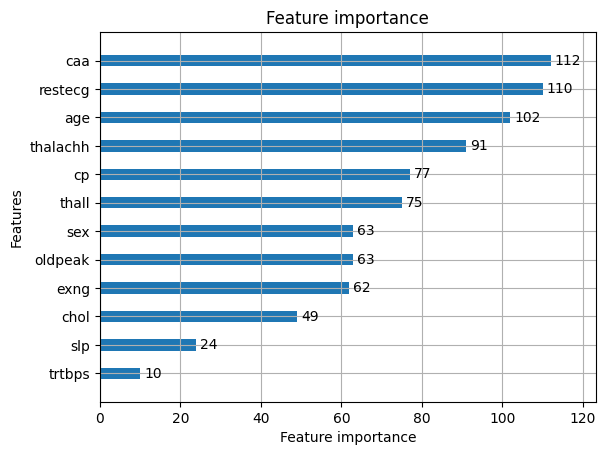

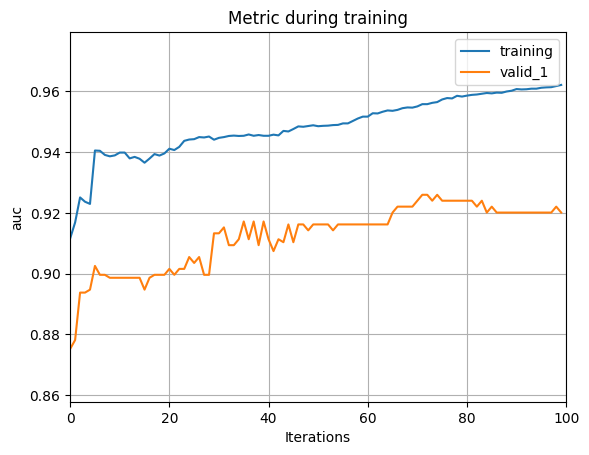

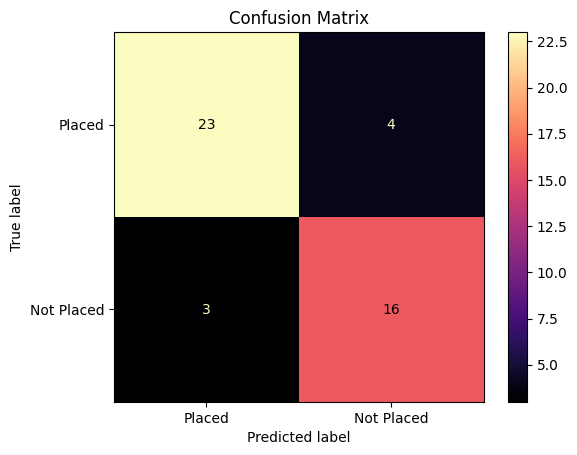

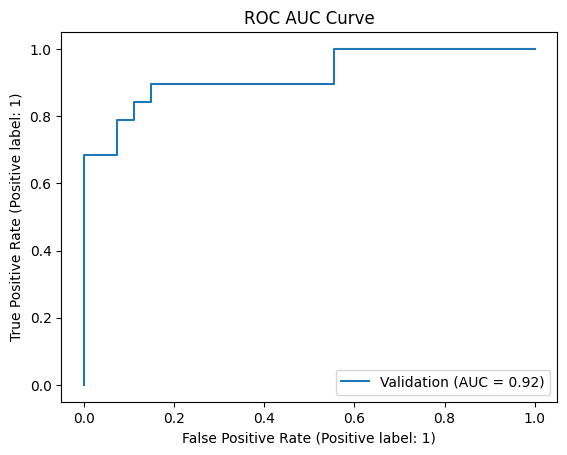

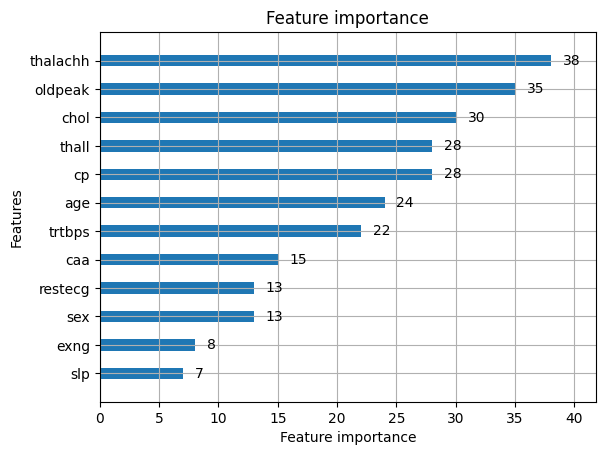

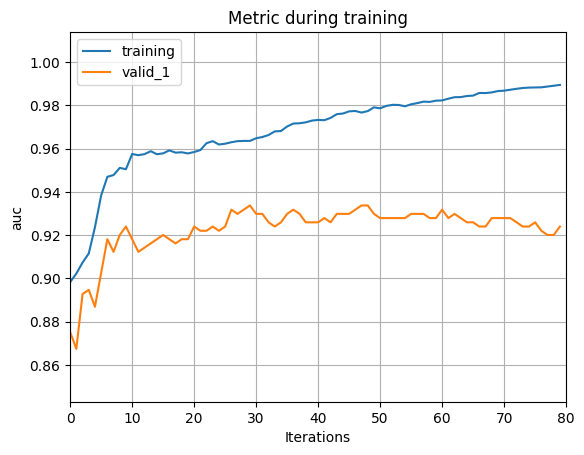

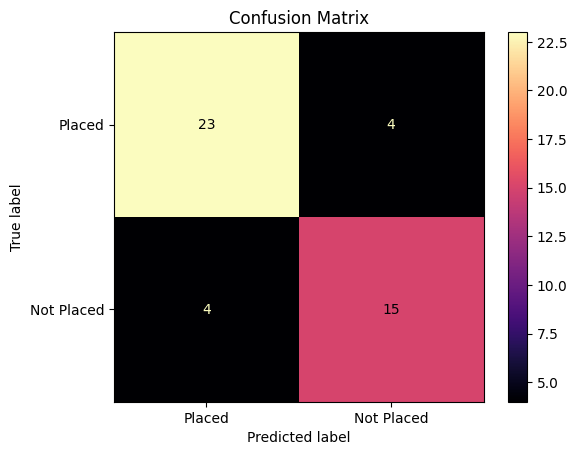

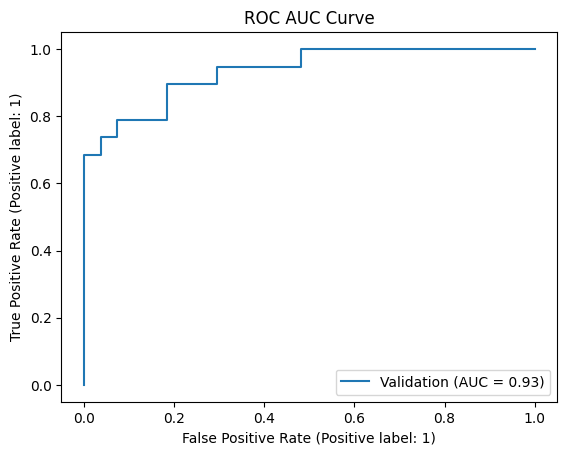

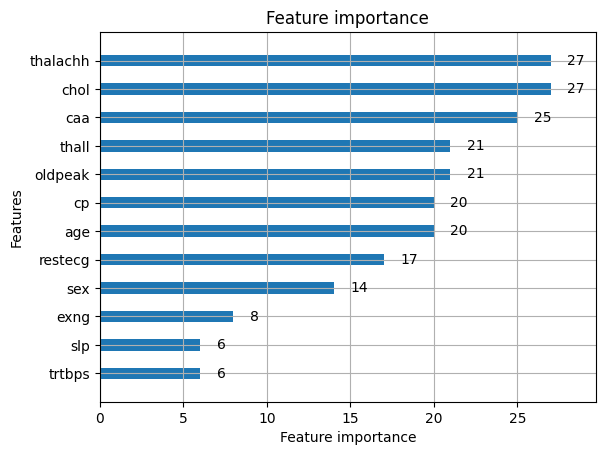

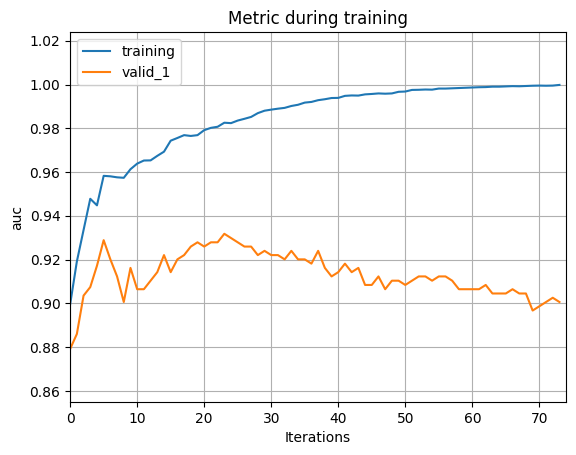

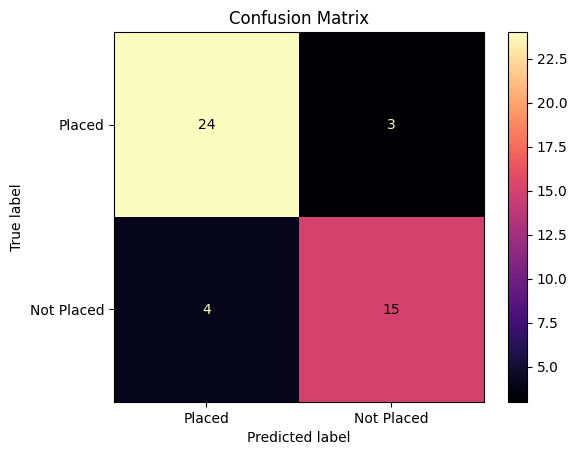

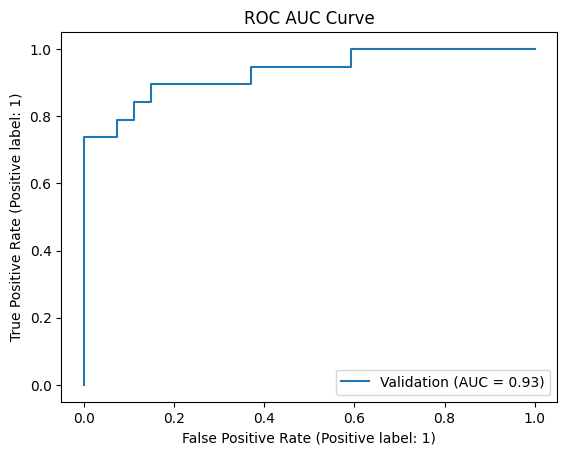

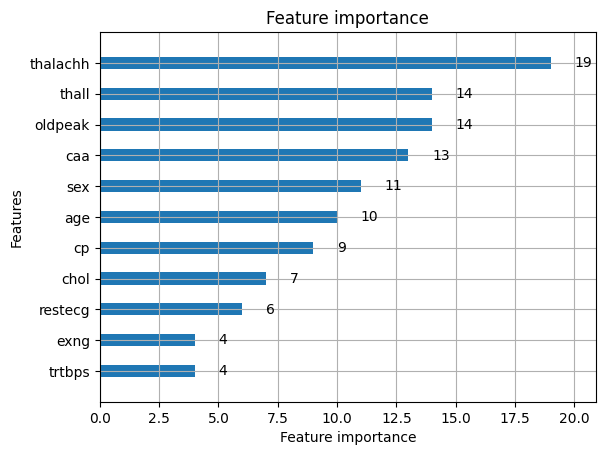

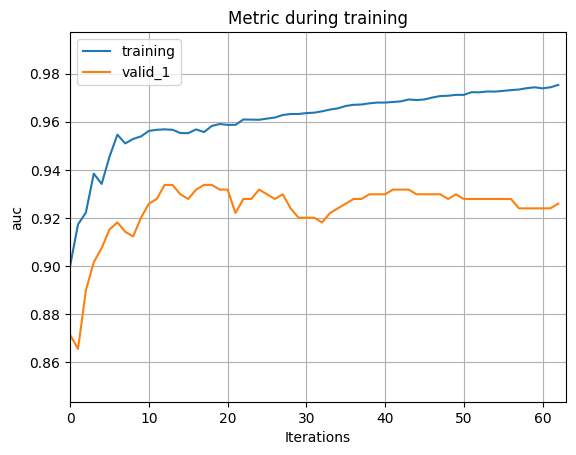

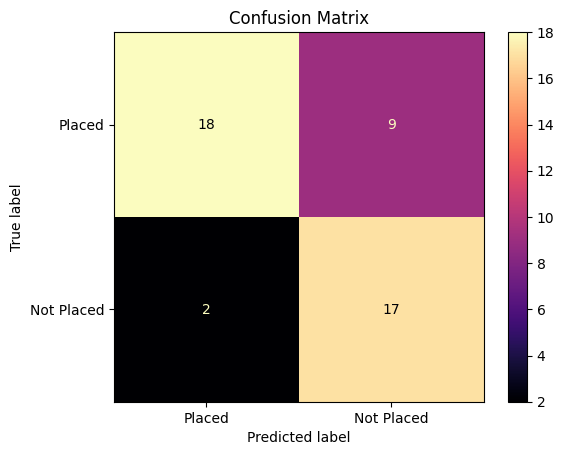

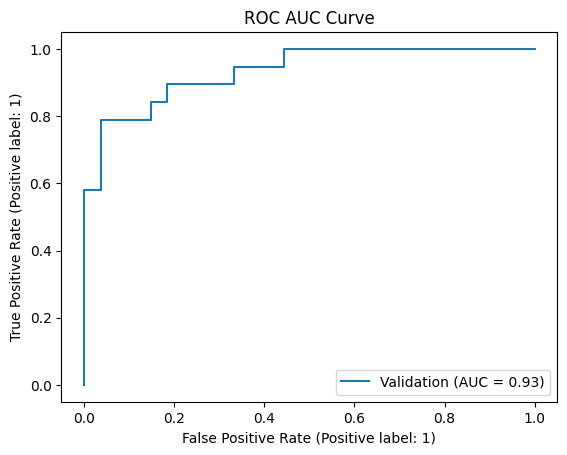

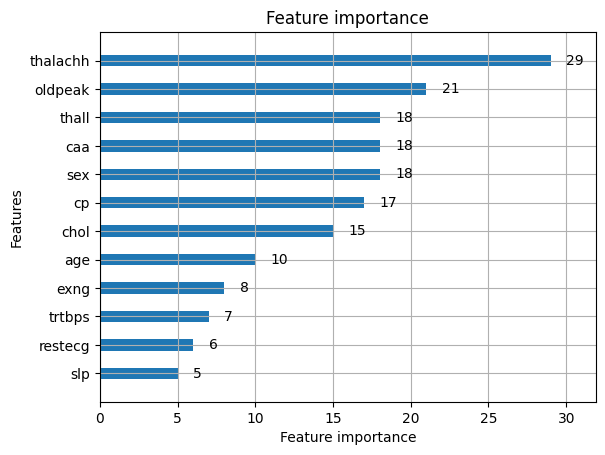

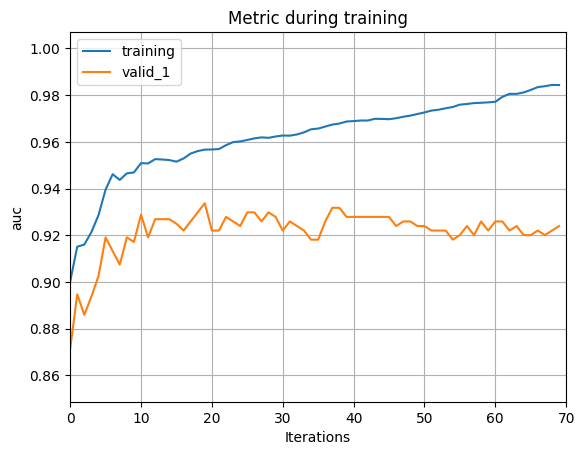

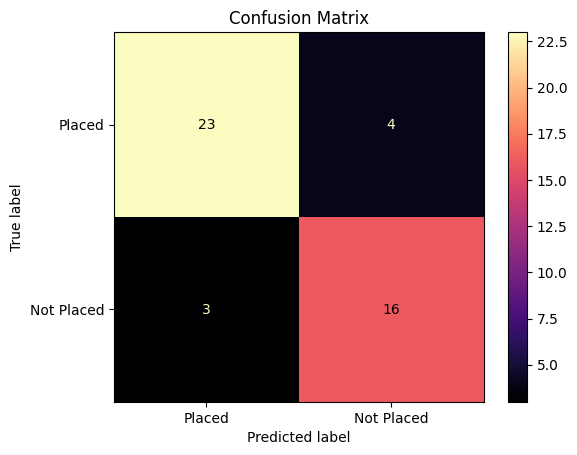

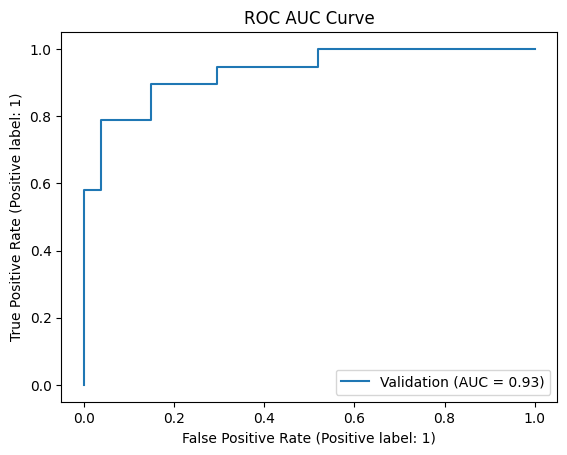

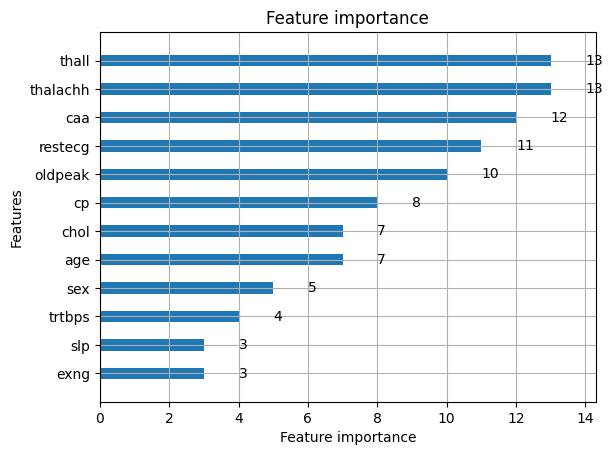

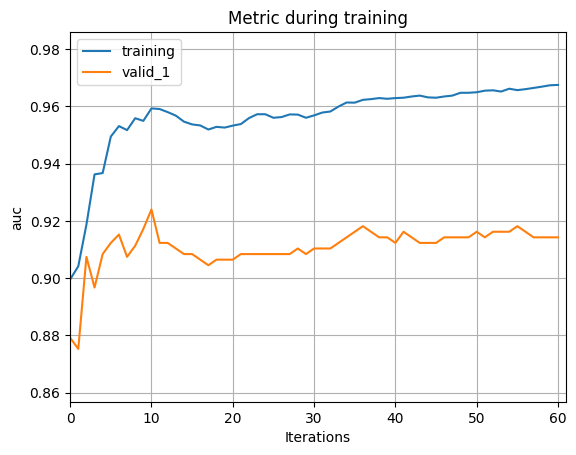

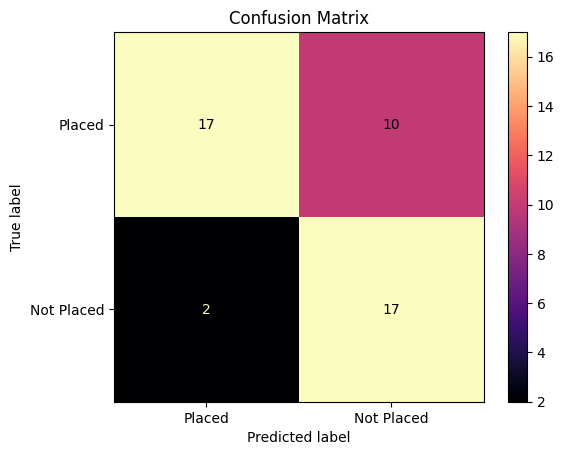

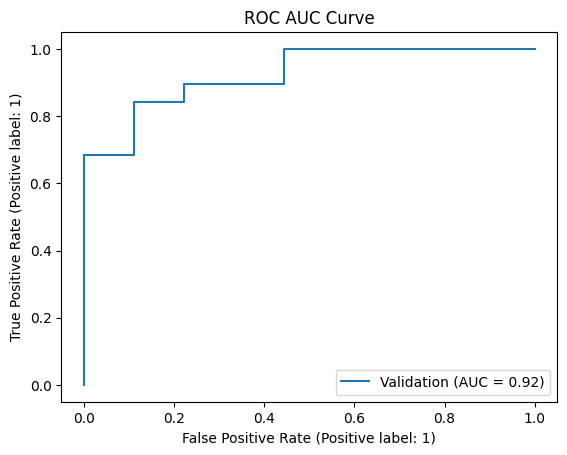

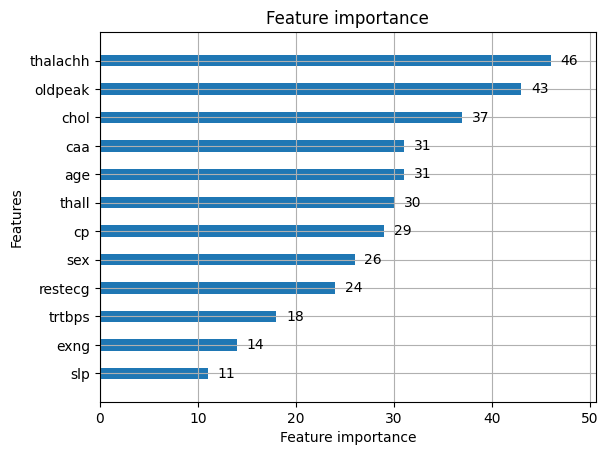

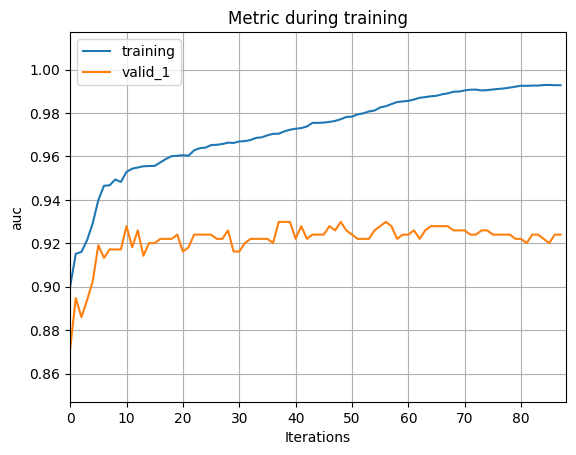

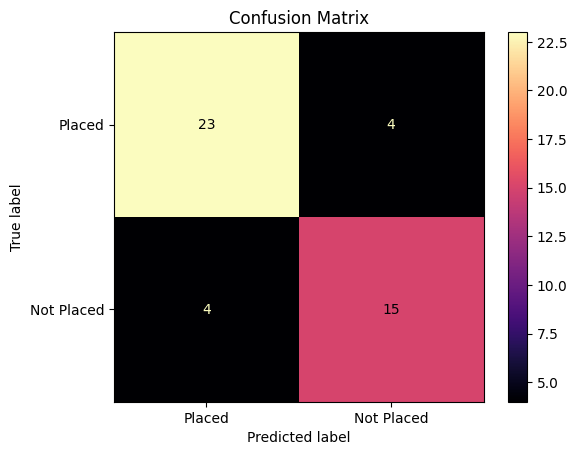

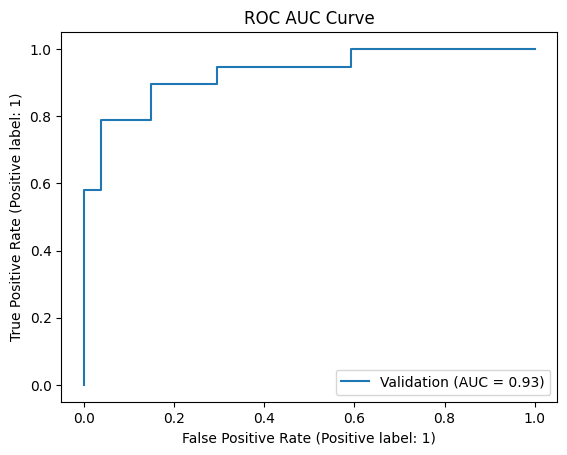

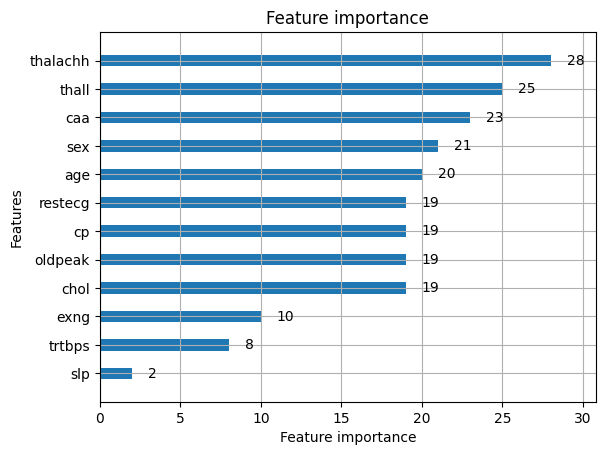

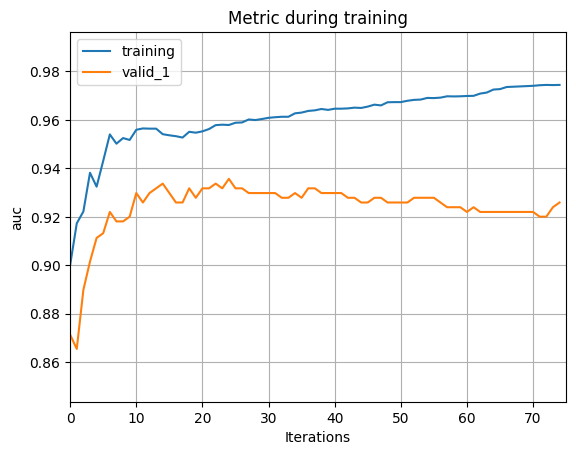

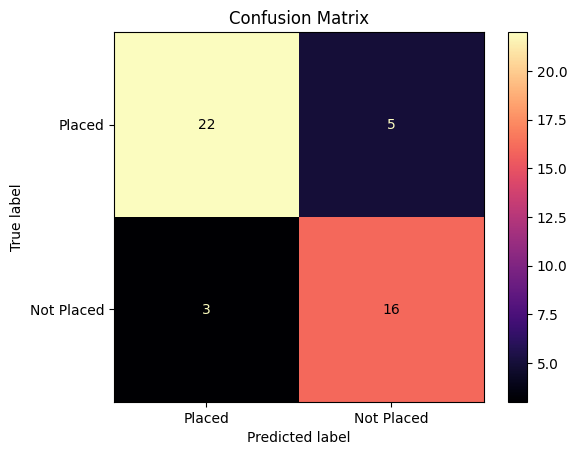

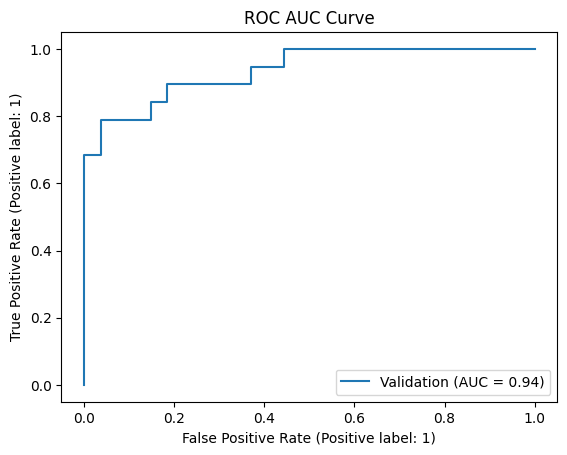

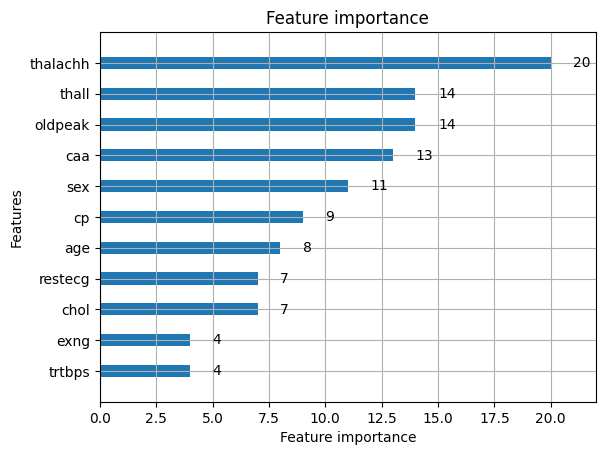

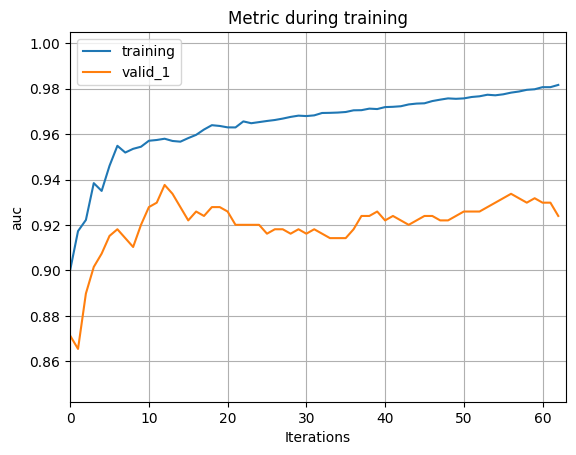

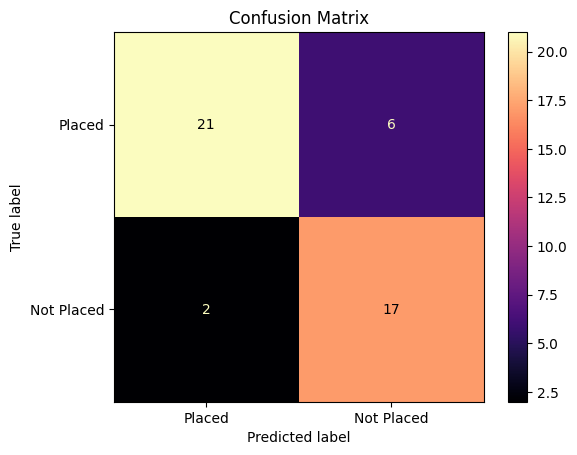

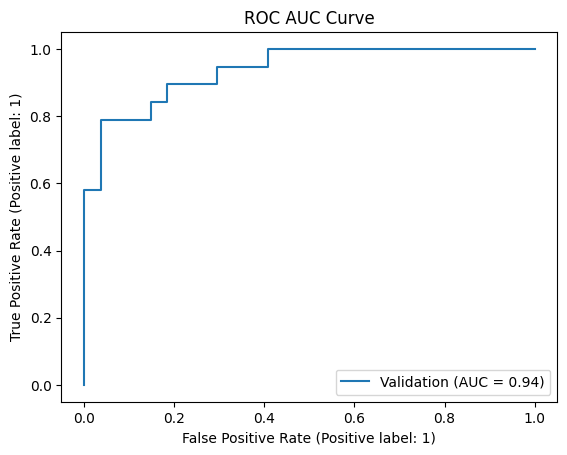

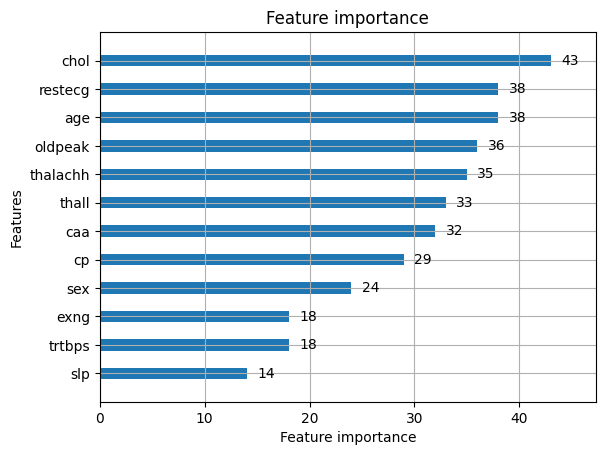

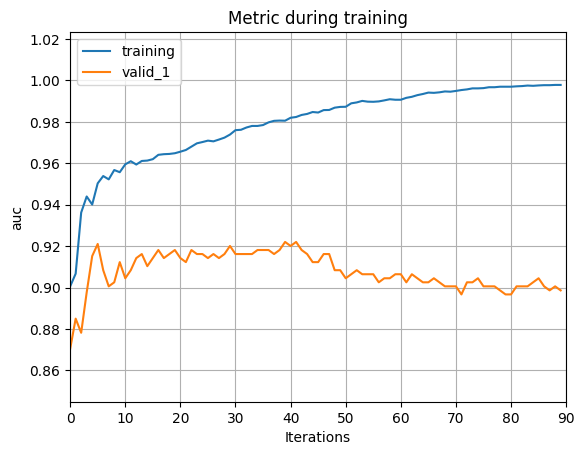

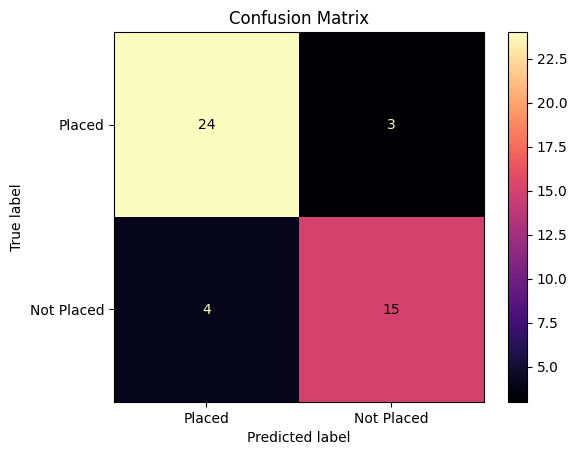

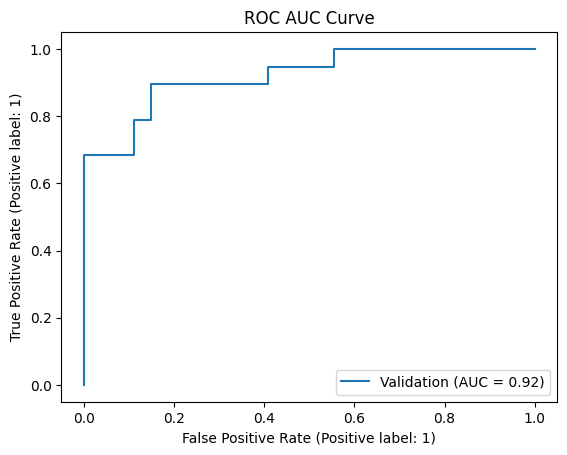

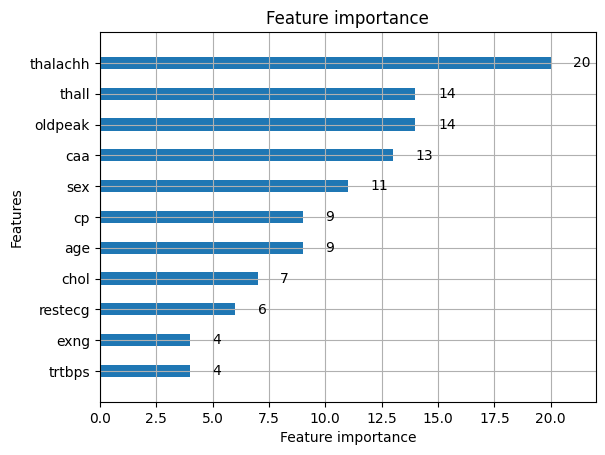

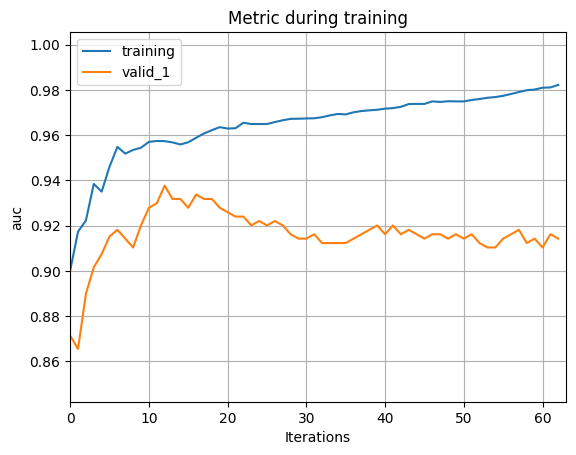

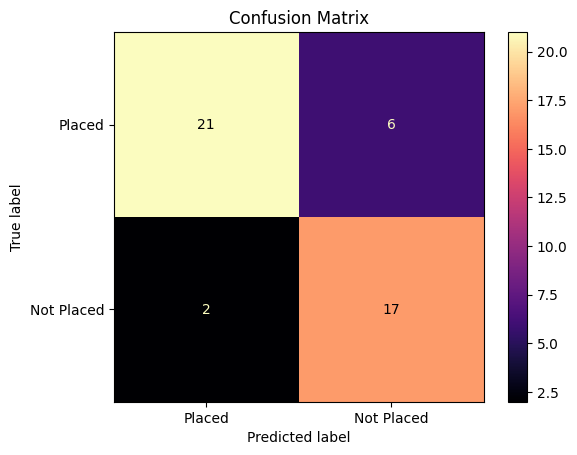

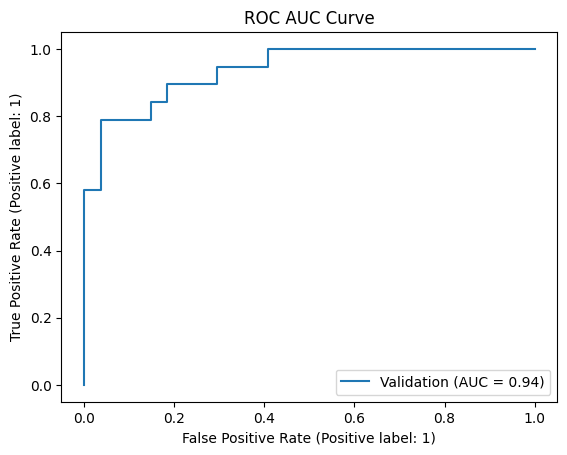

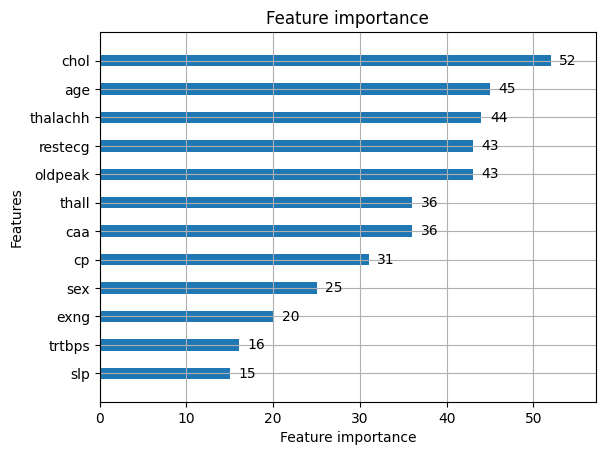

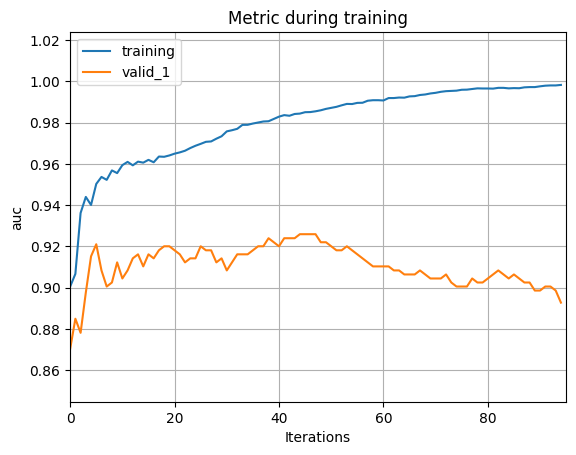

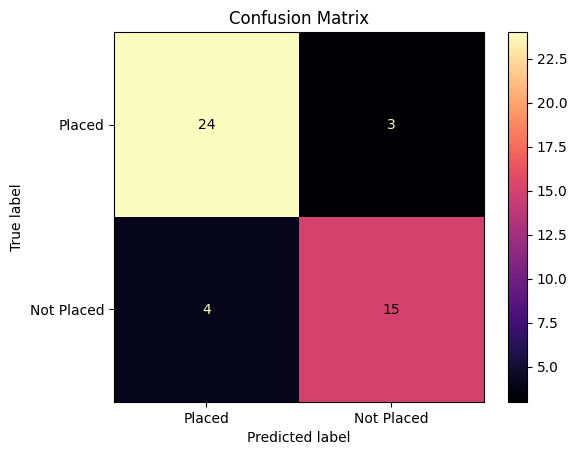

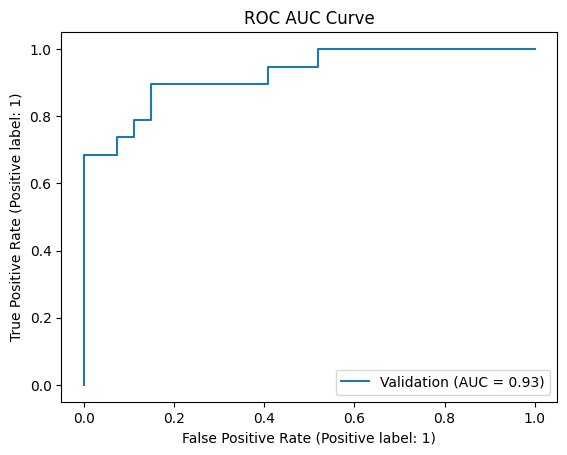

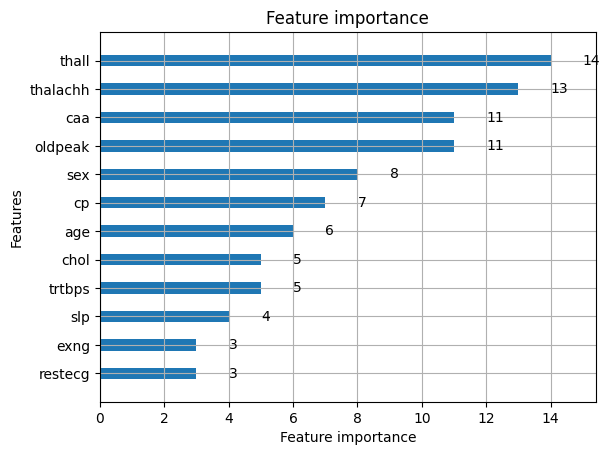

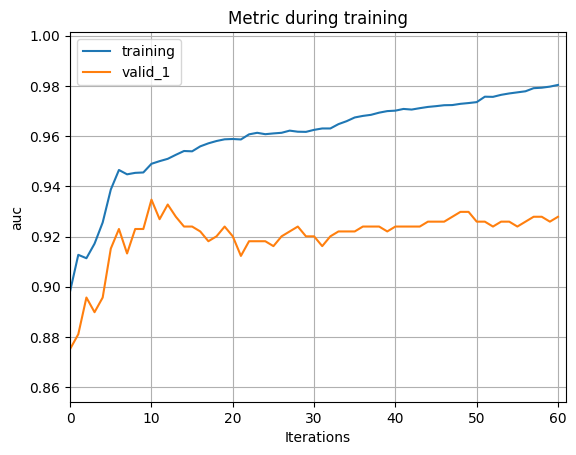

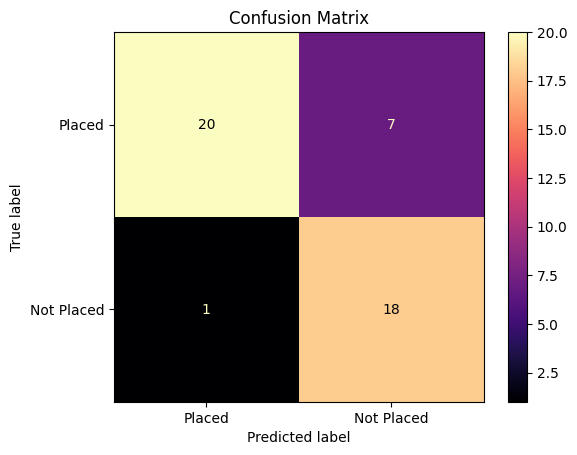

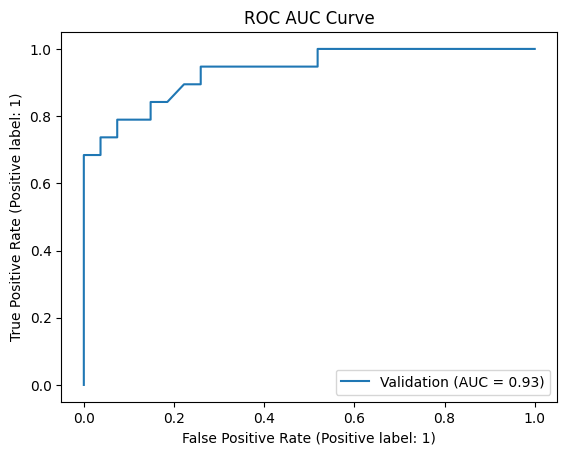

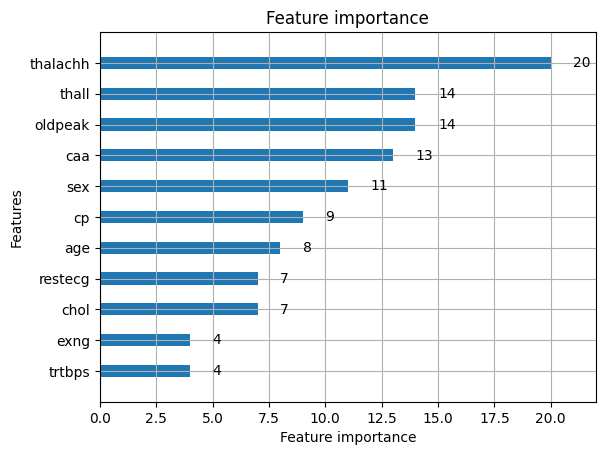

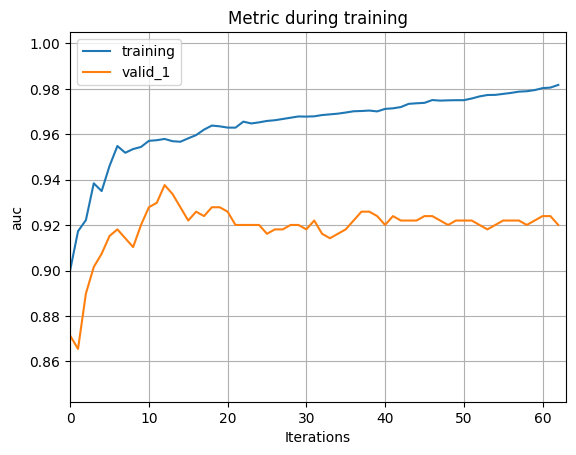

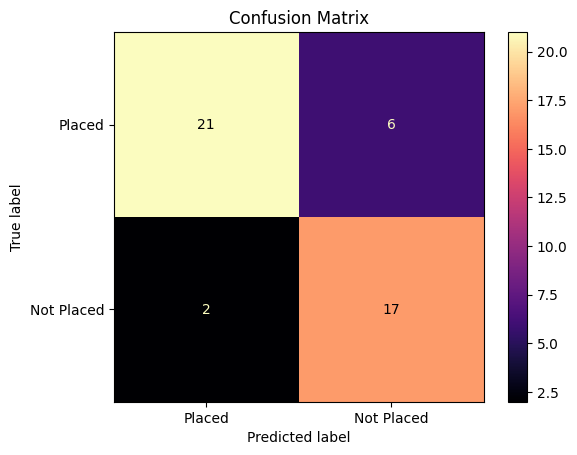

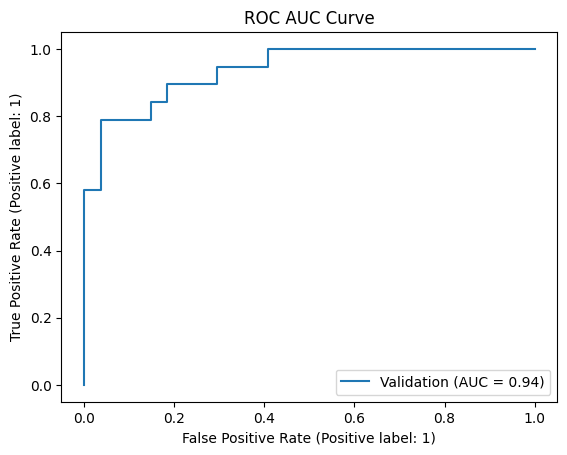

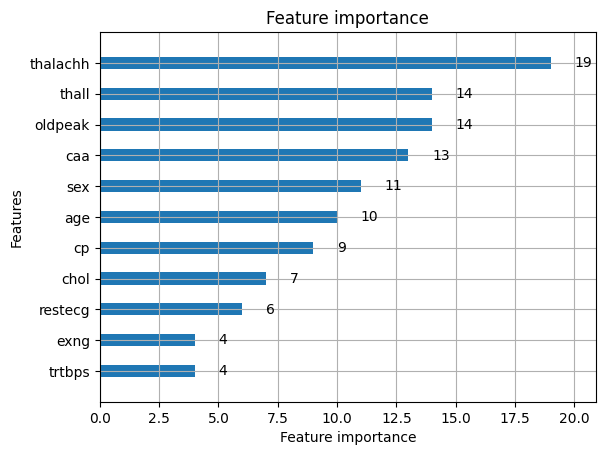

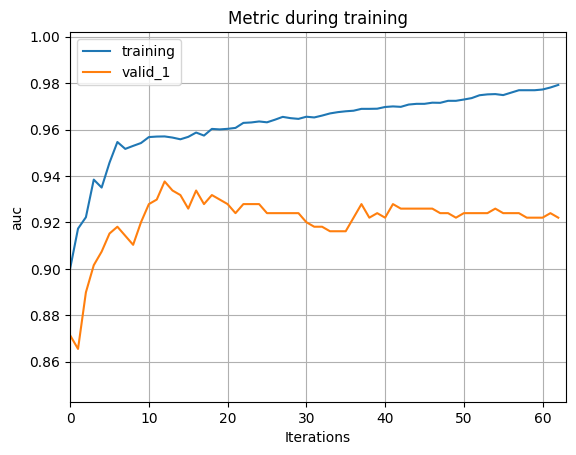

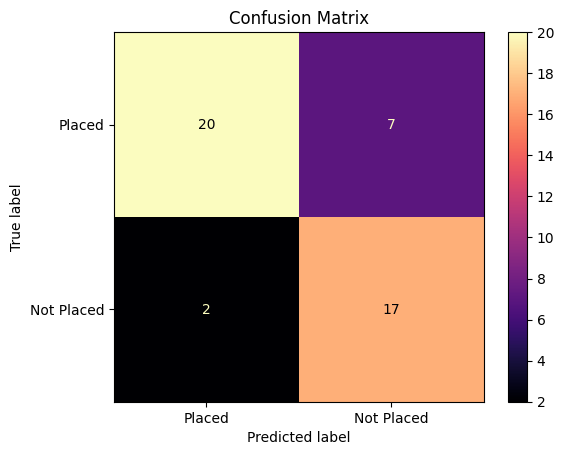

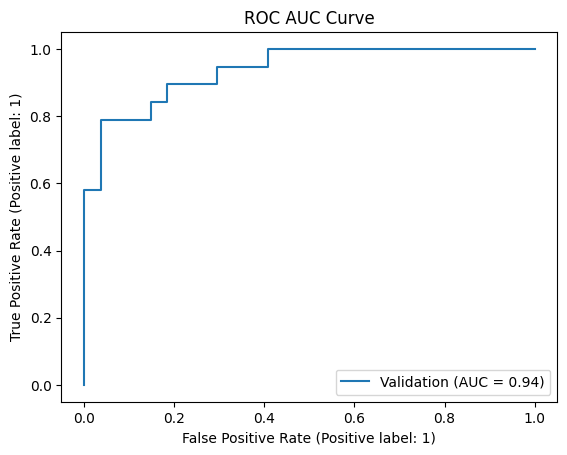

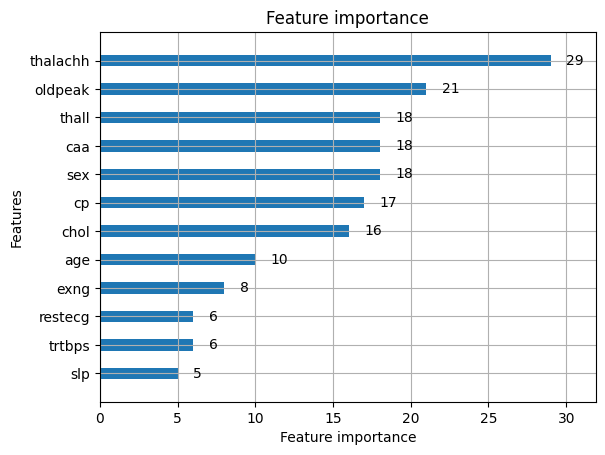

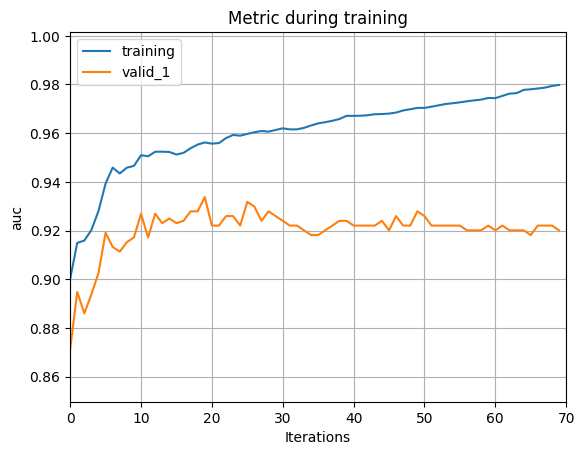

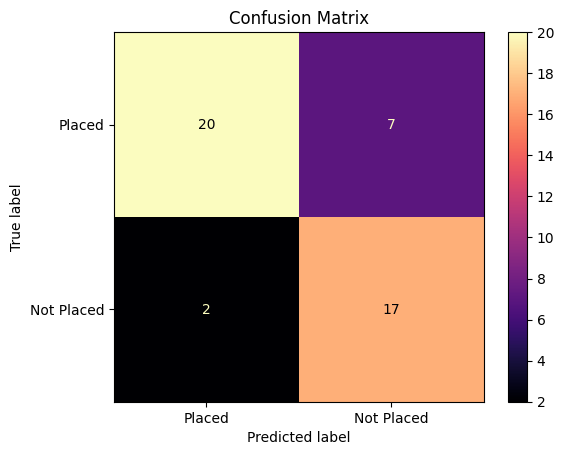

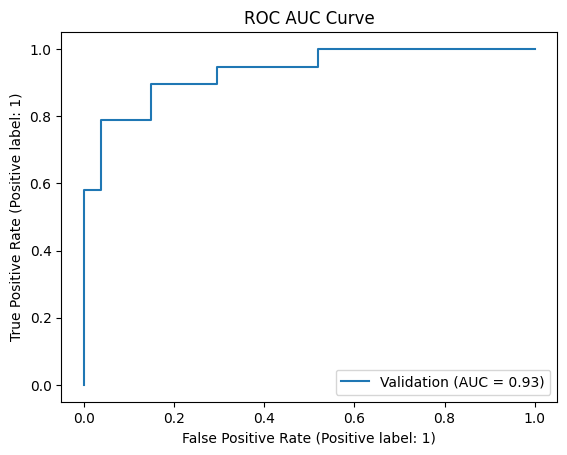

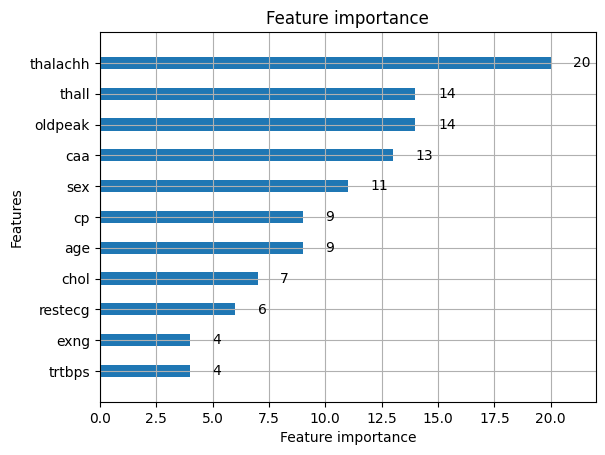

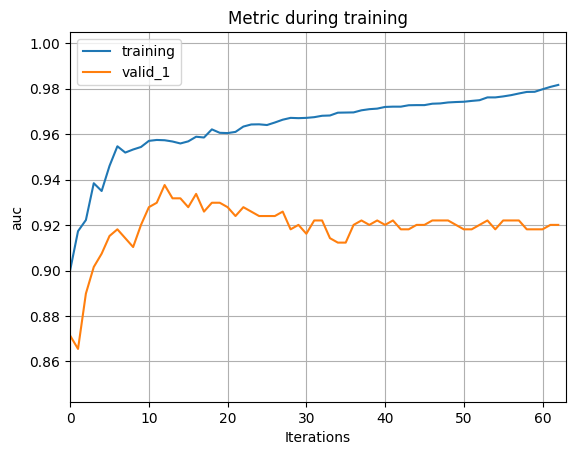

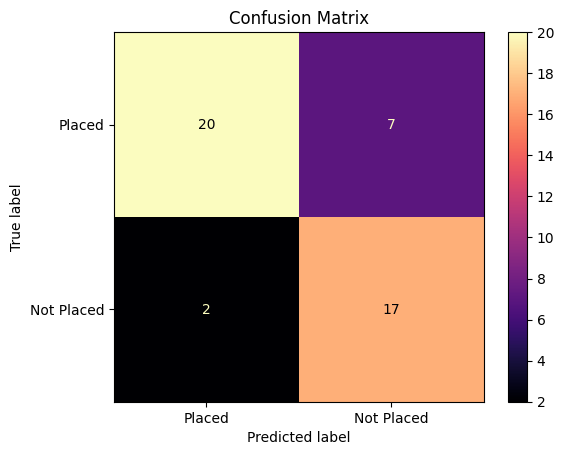

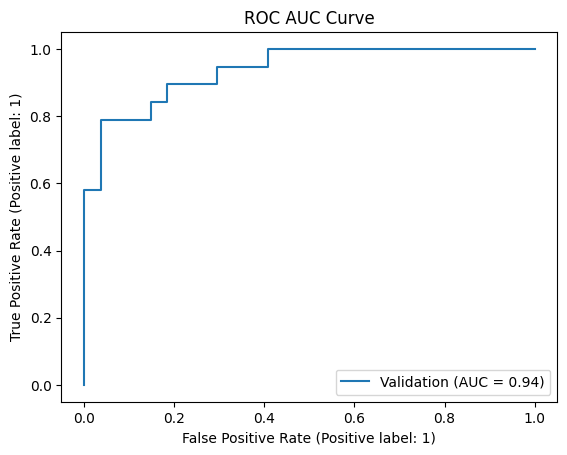

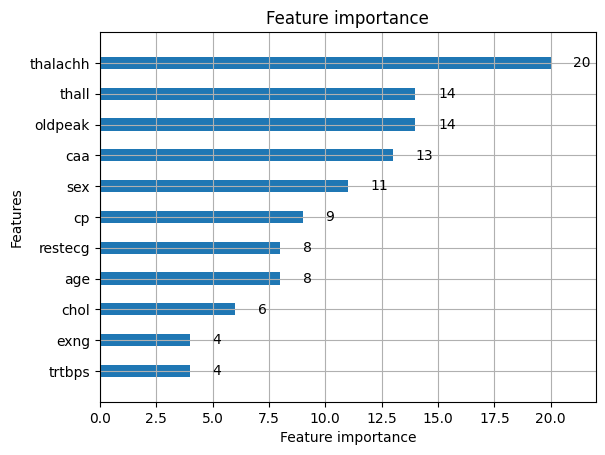

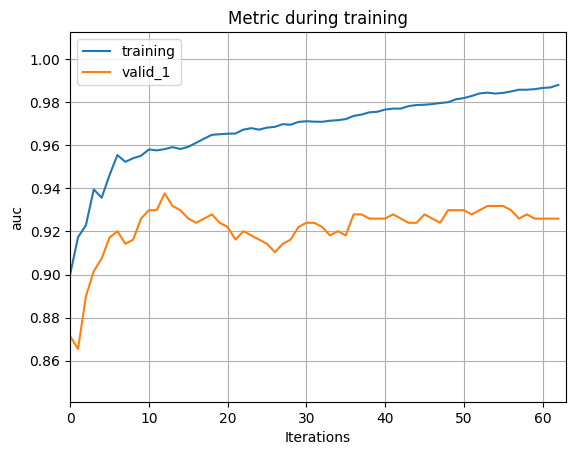

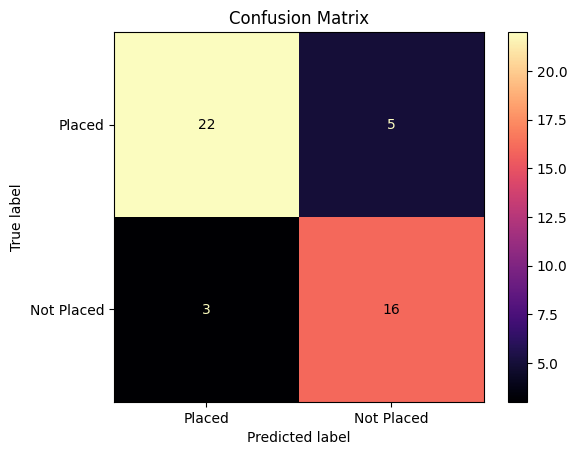

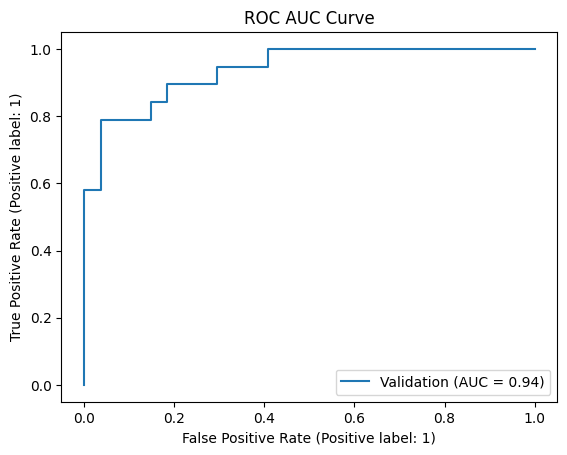

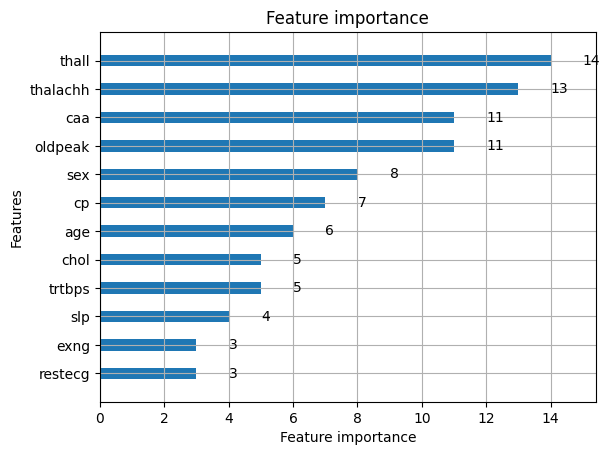

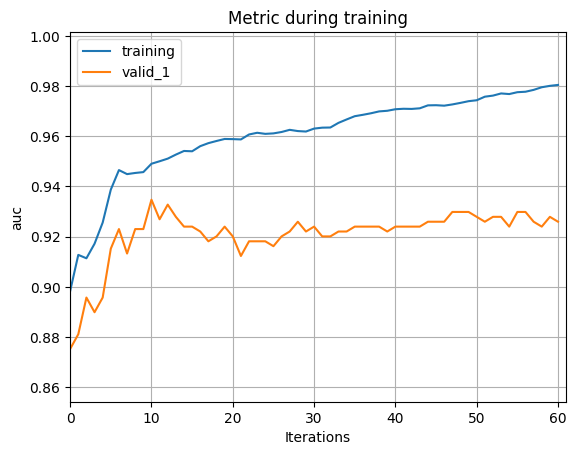

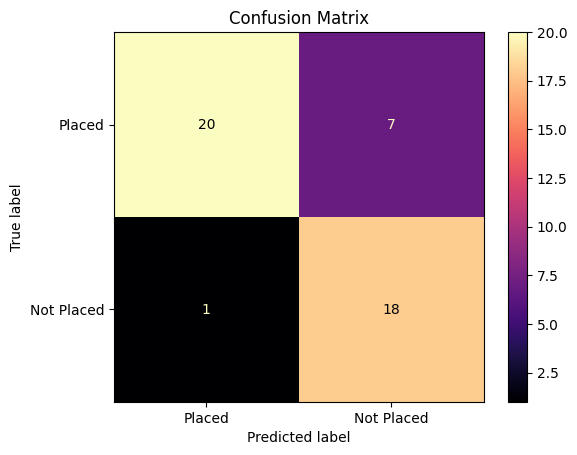

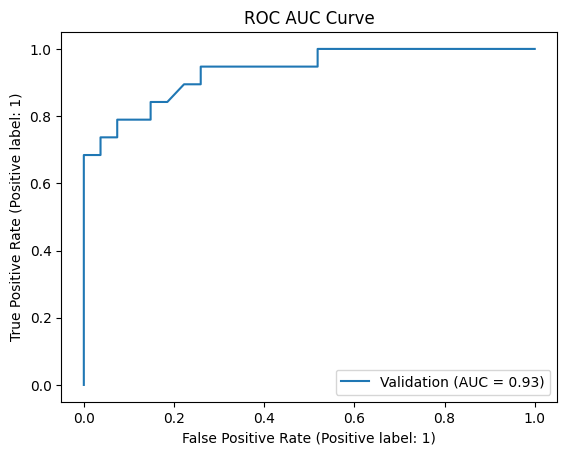

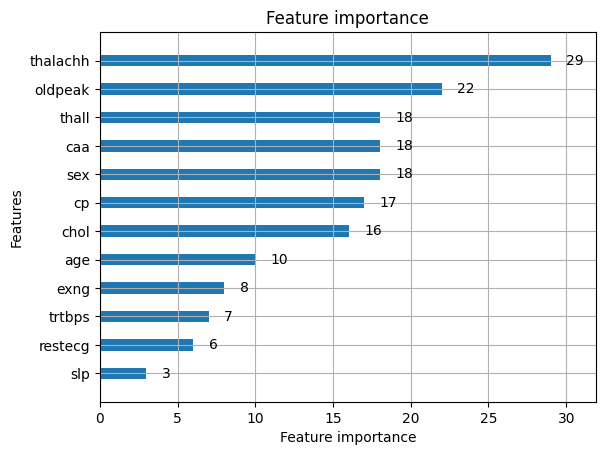

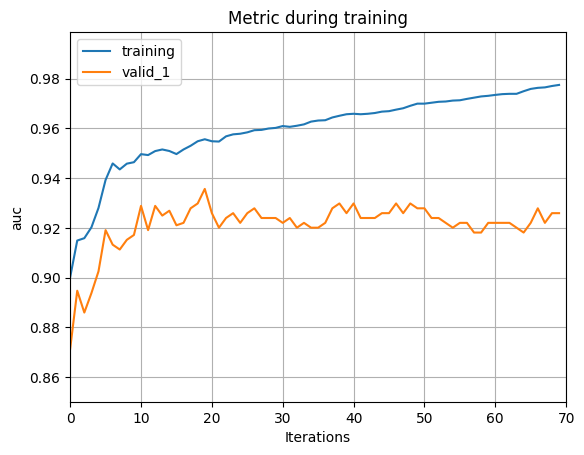

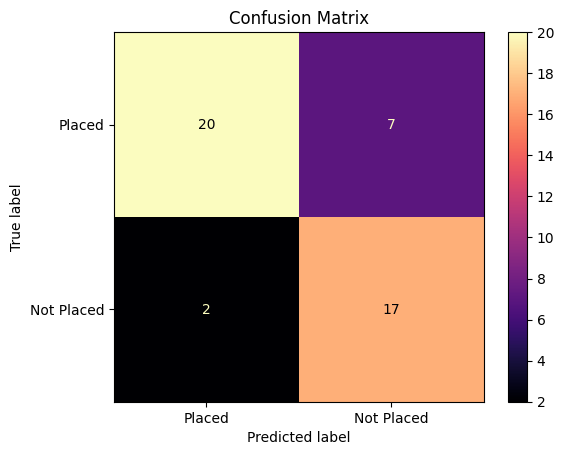

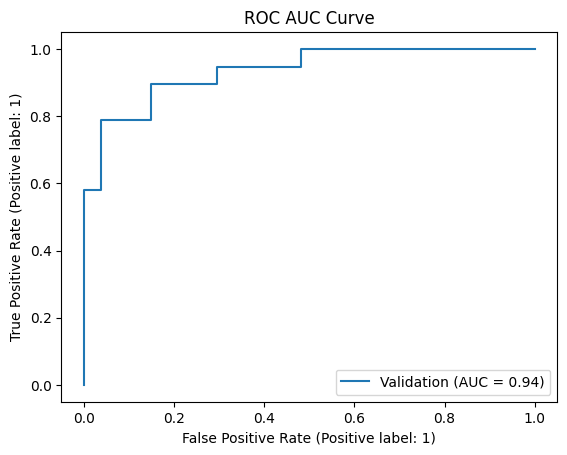

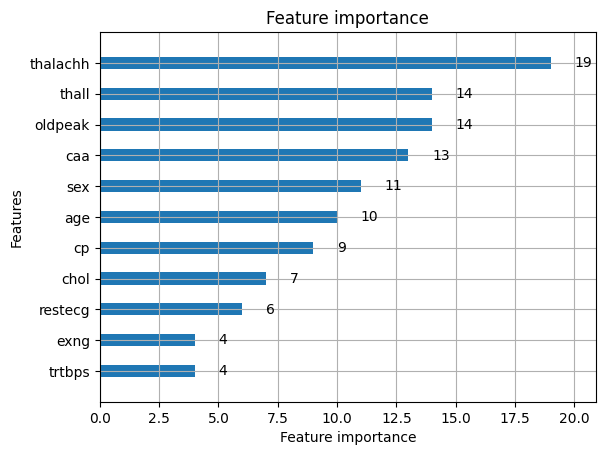

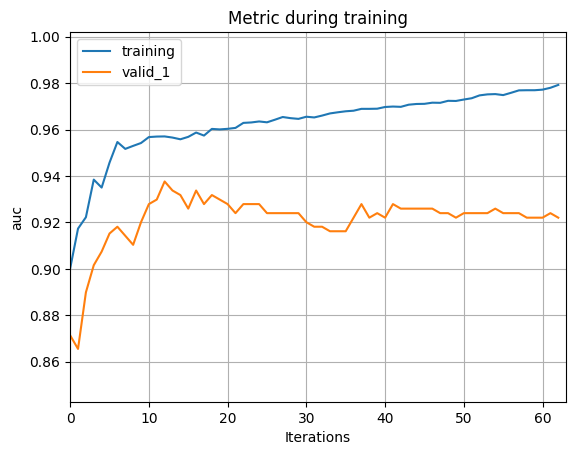

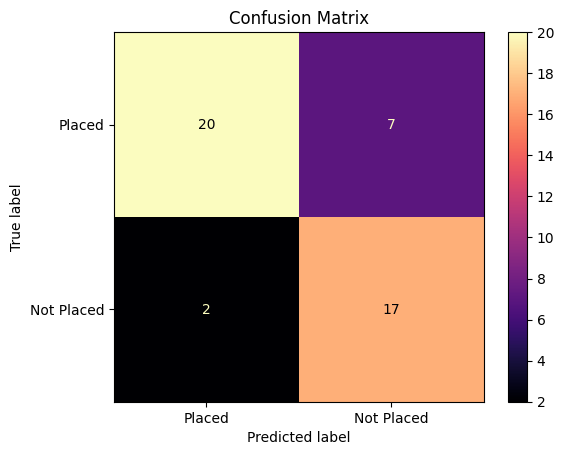

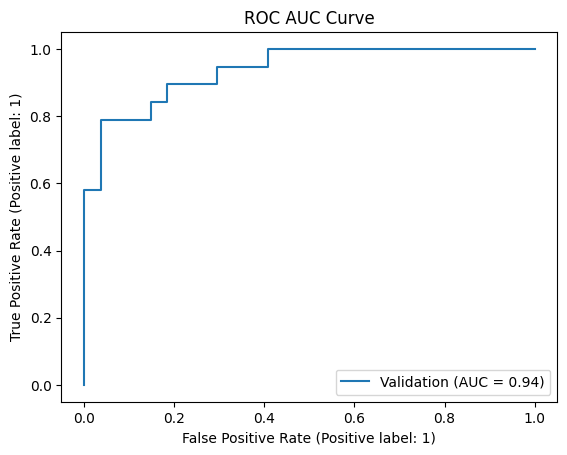

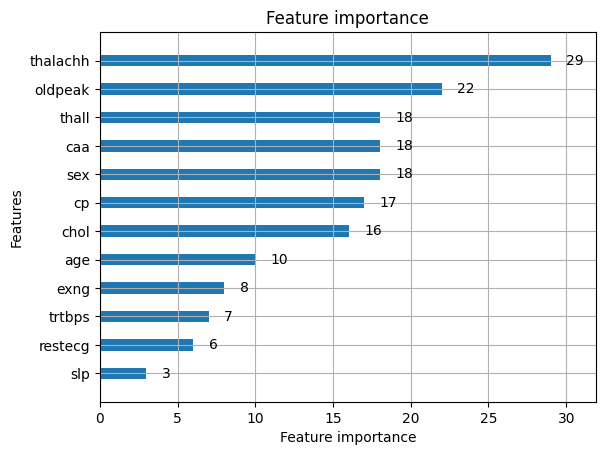

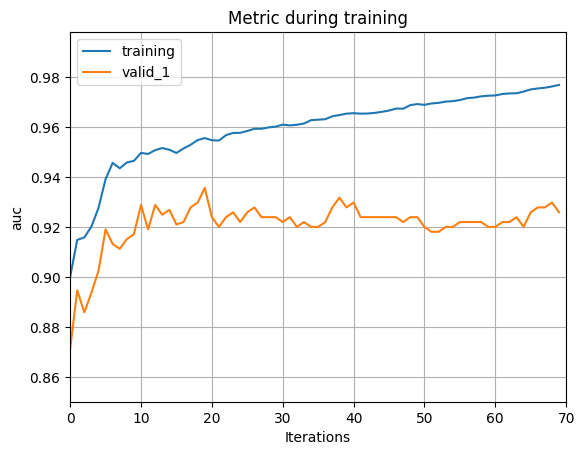

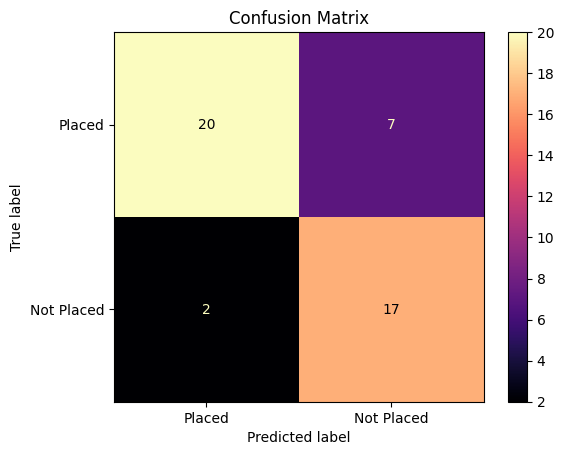

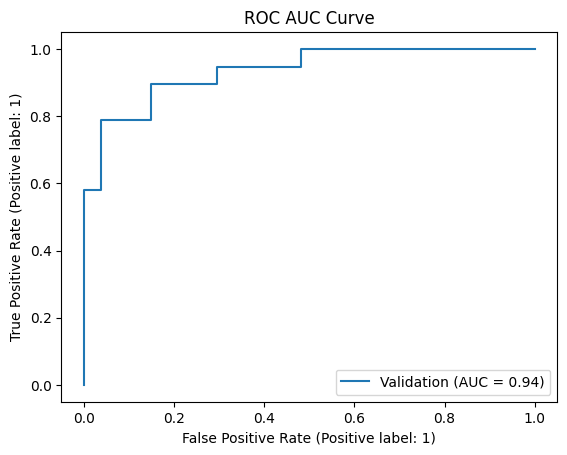

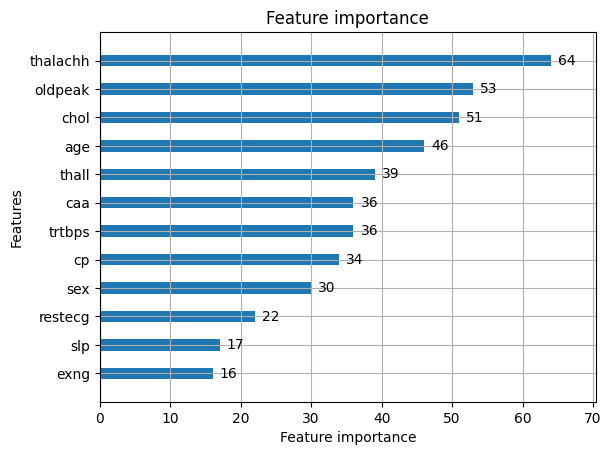

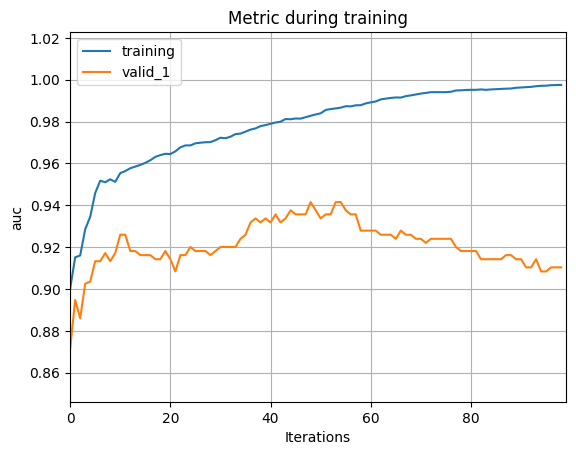

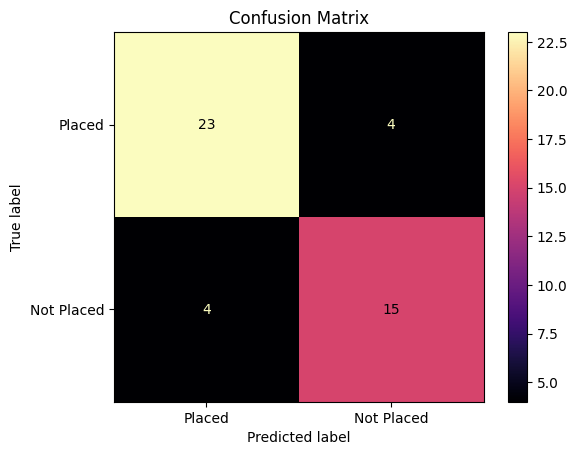

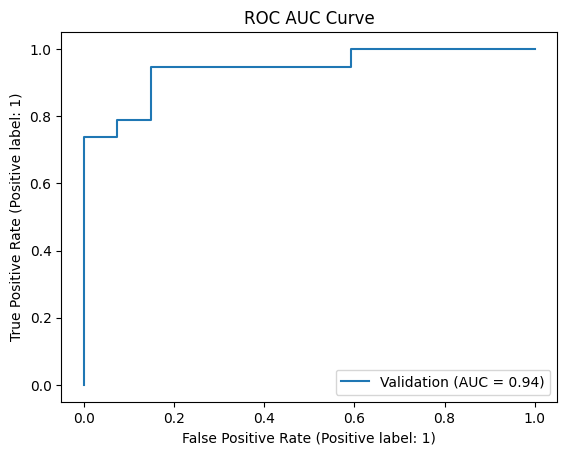

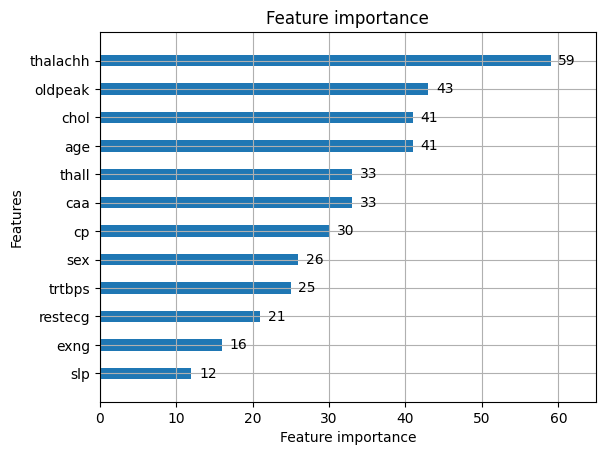

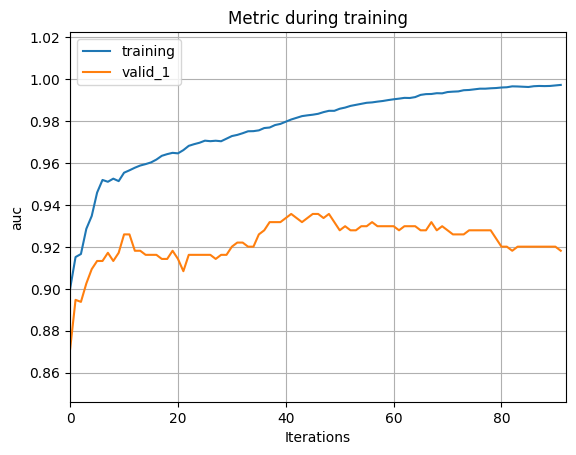

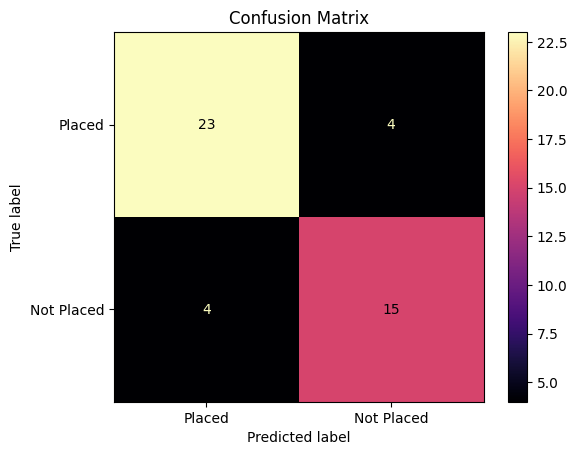

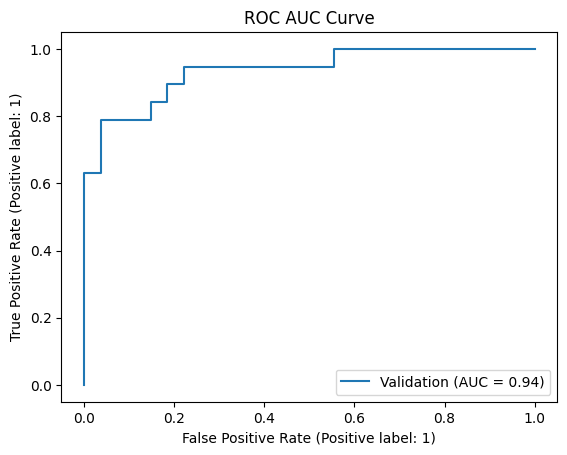

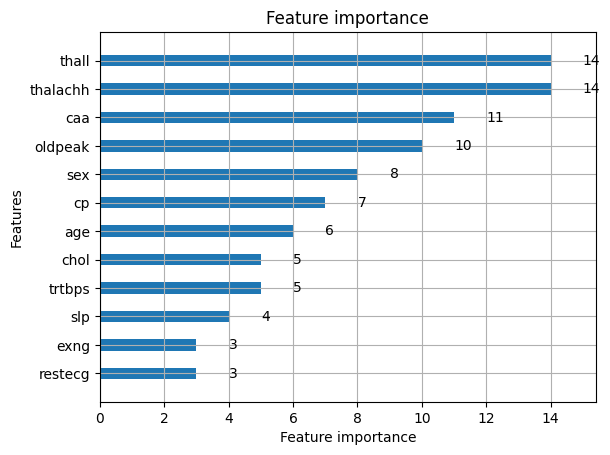

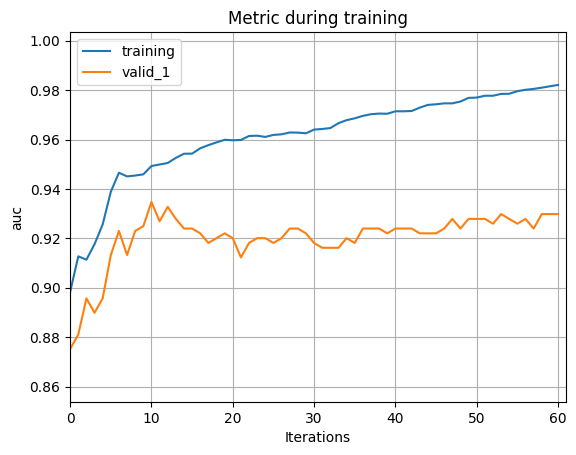

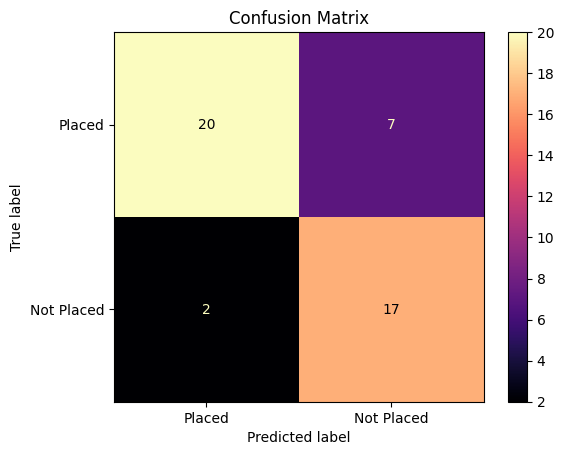

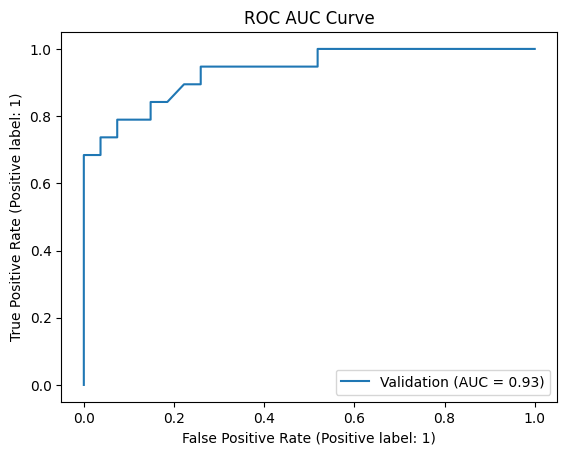

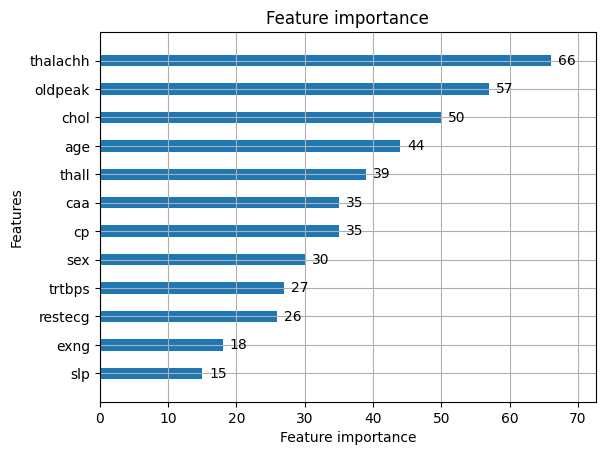

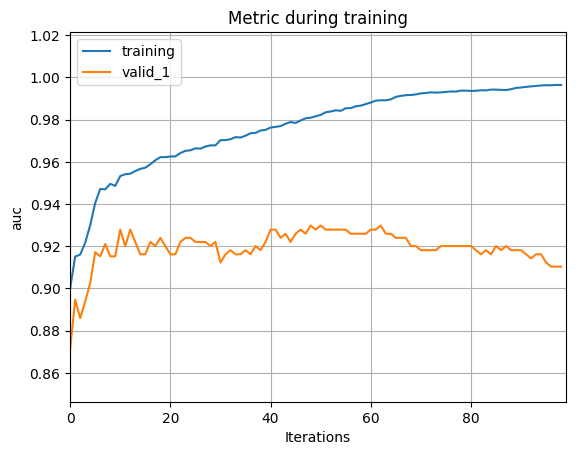

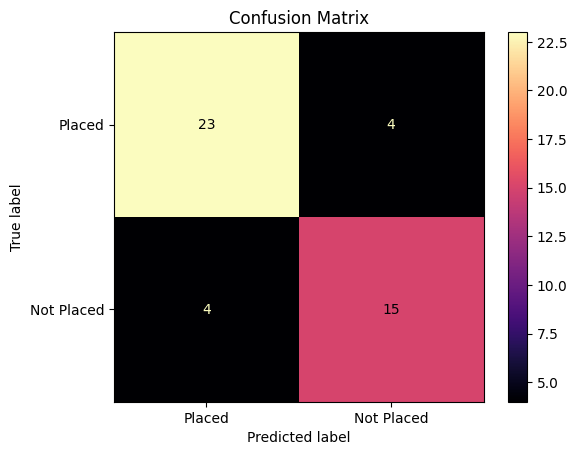

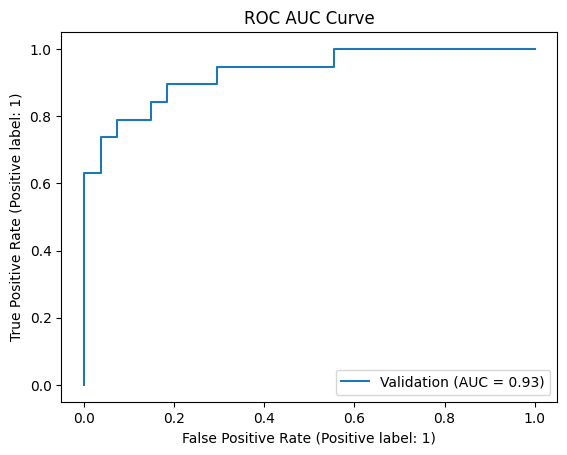

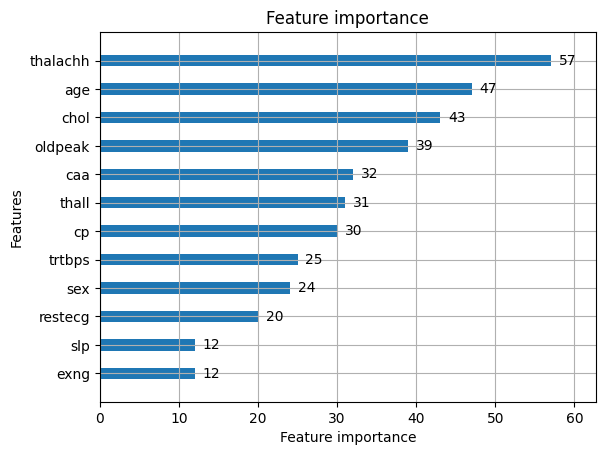

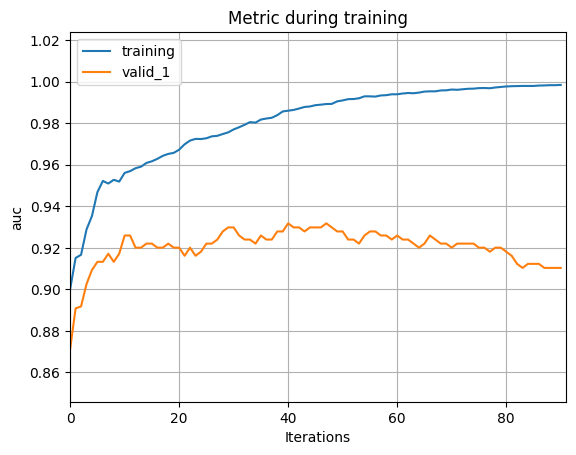

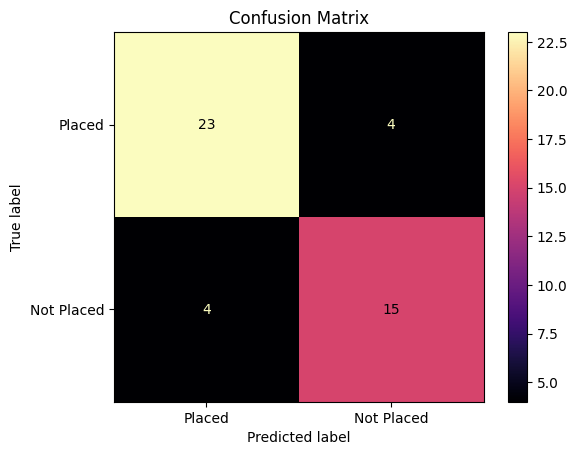

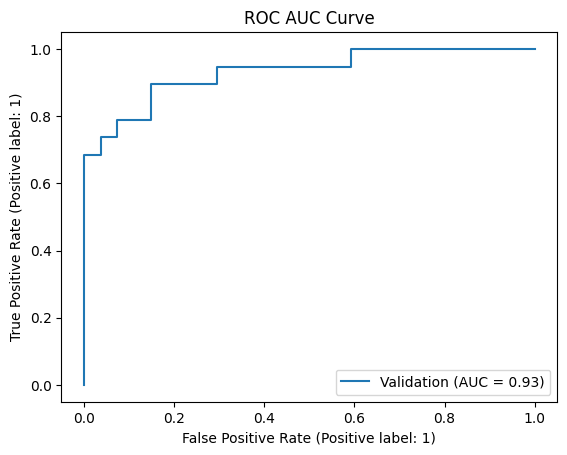

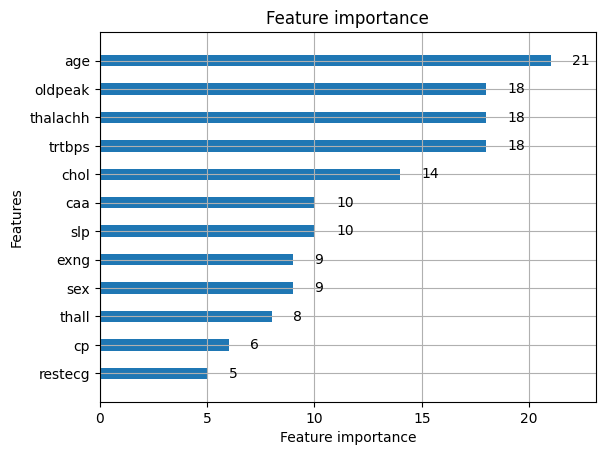

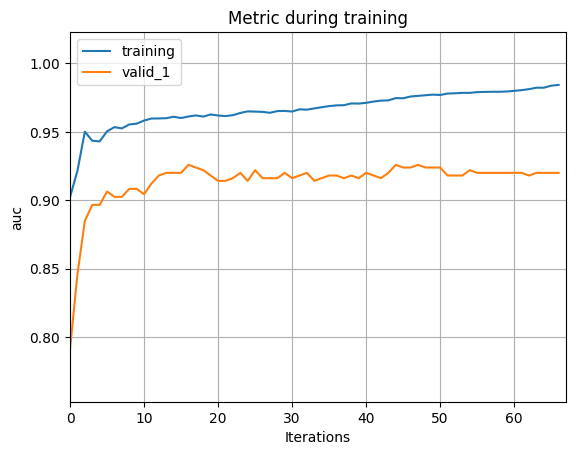

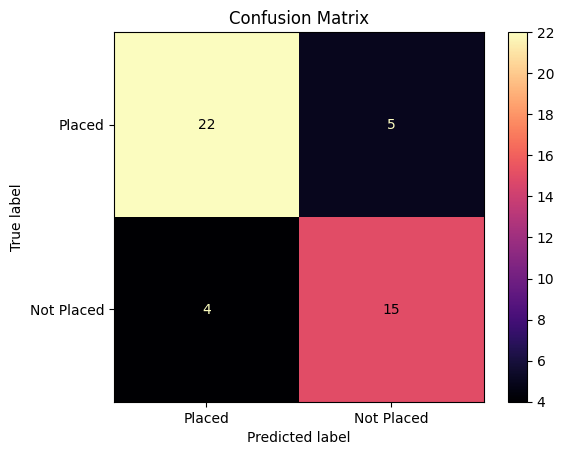

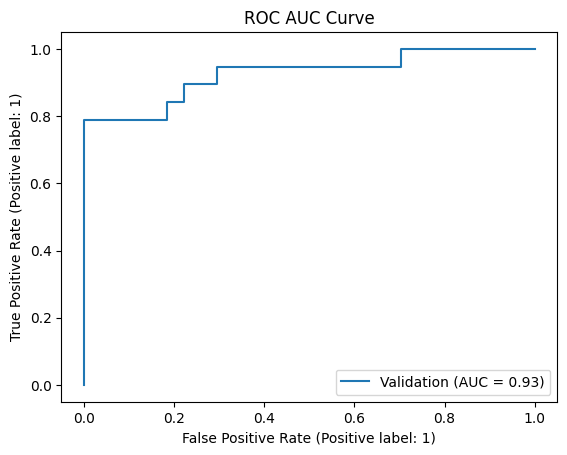

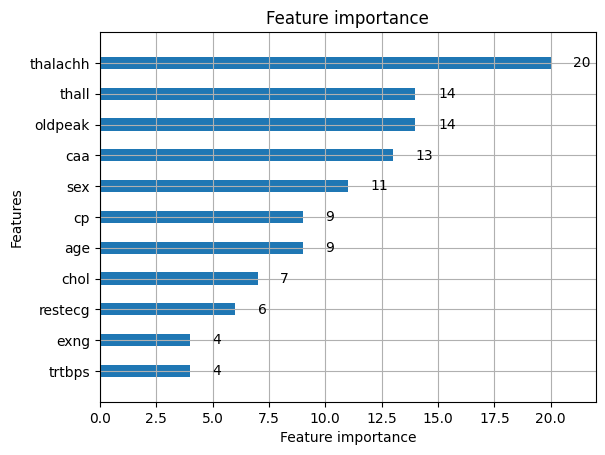

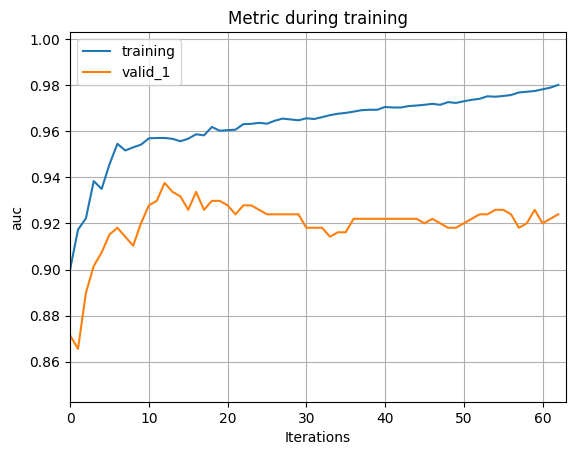

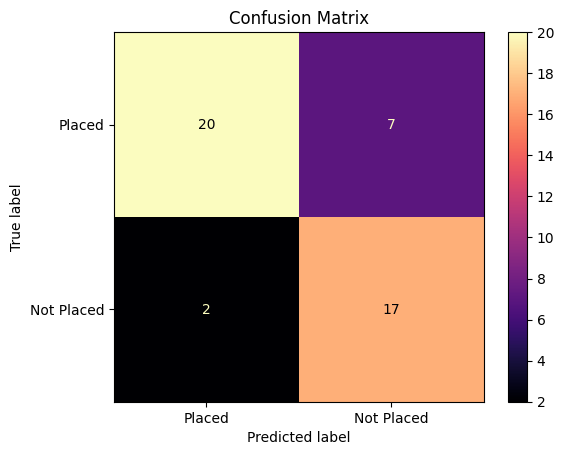

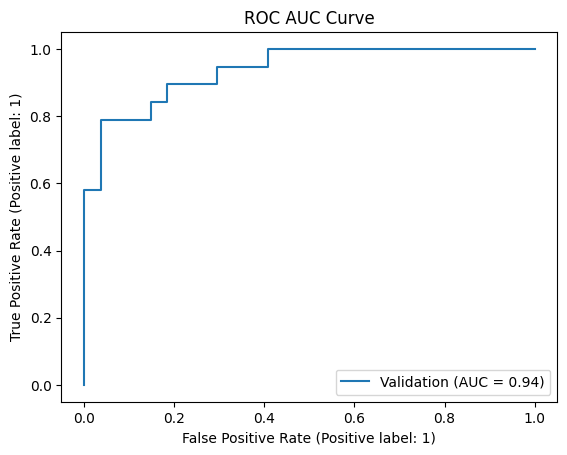

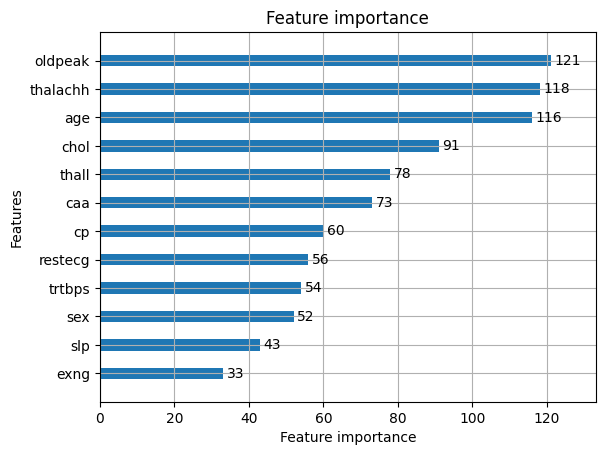

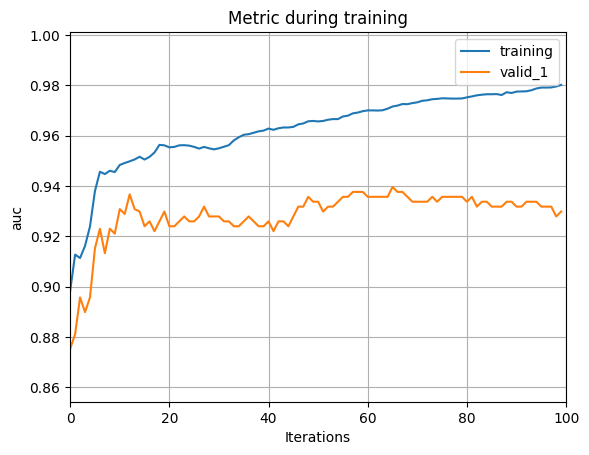

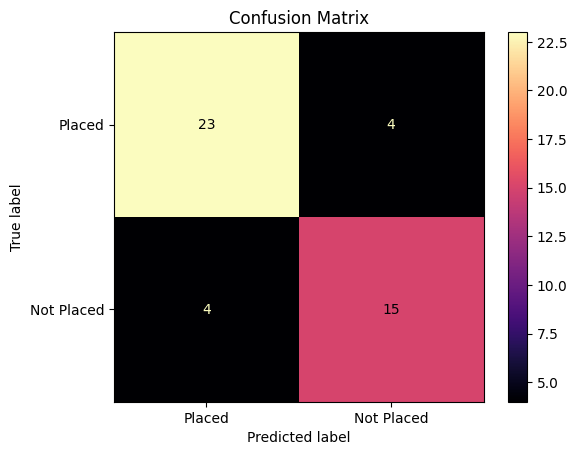

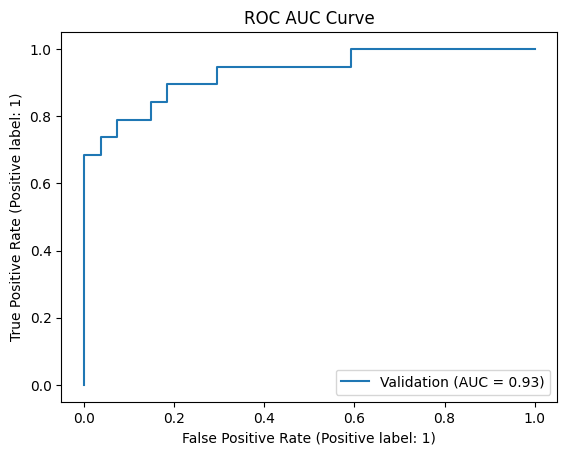

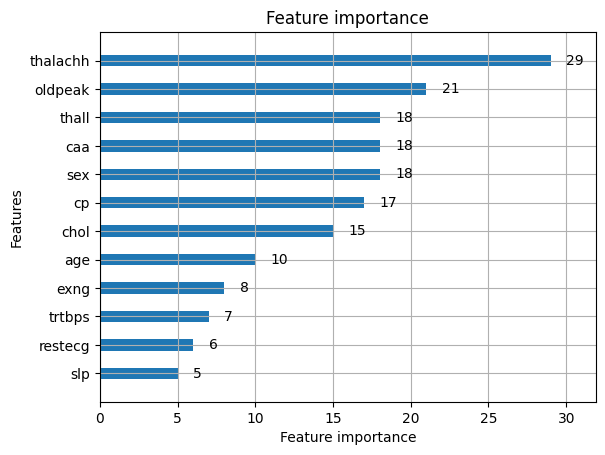

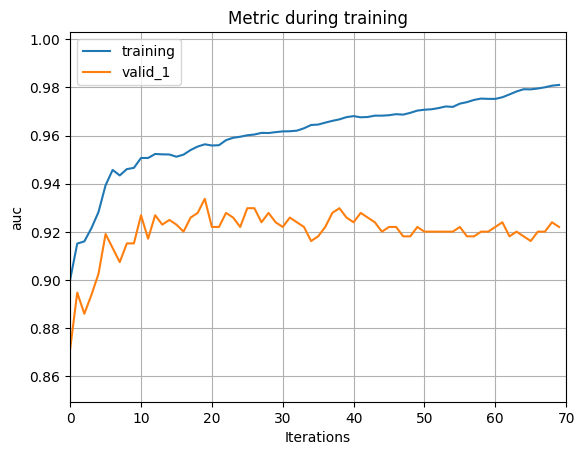

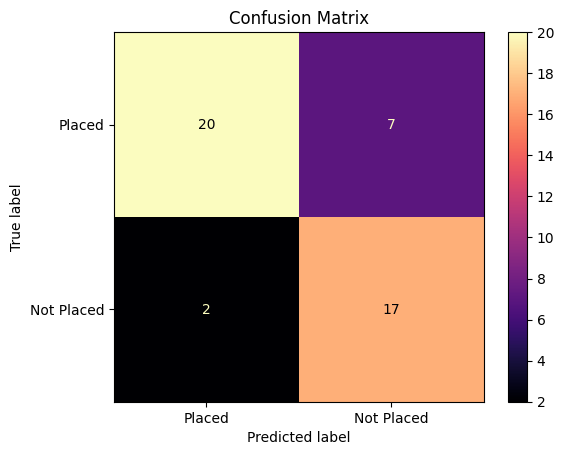

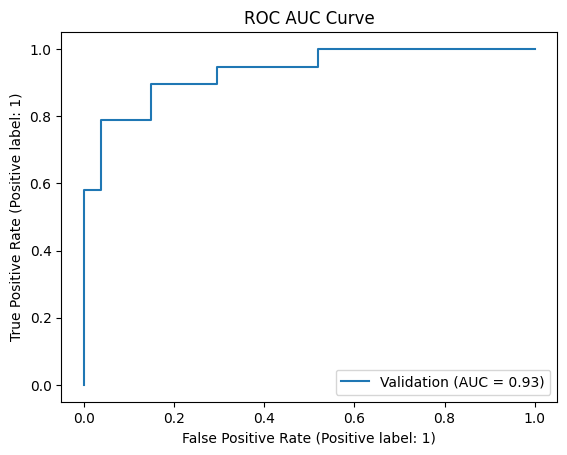

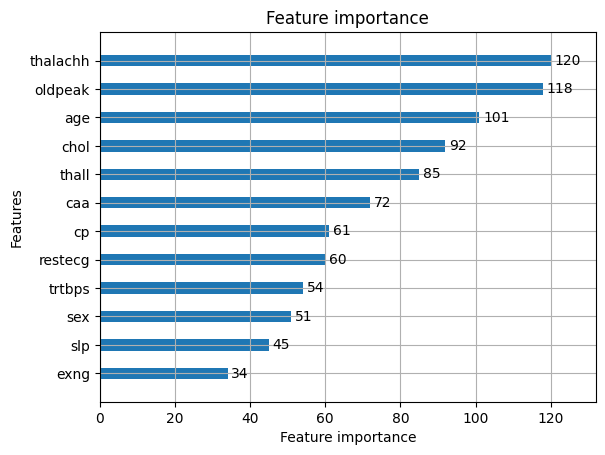

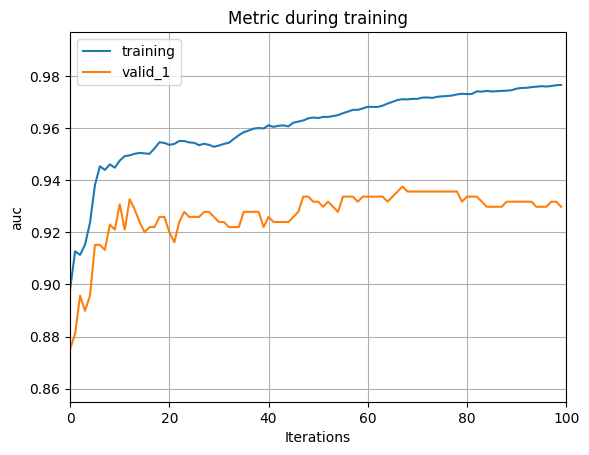

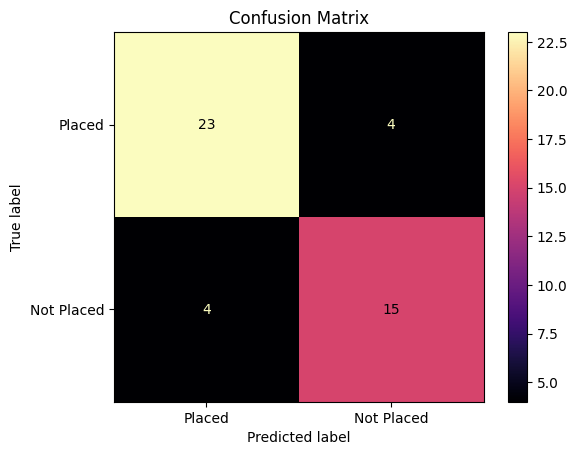

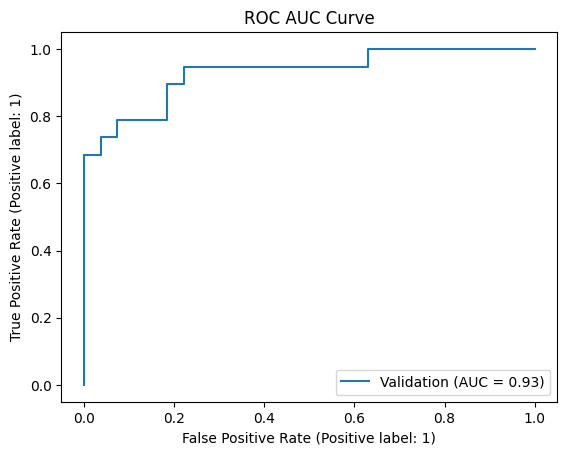

In [15]:
# Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)
trial = study.best_trial
print('AUC: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

## Load best lightgbm model

Check Mlflow UI and pick the best model for model deployment

In [78]:
import mlflow 
client = mlflow.tracking.MlflowClient()
runs = client.search_runs(experiment_id, "", order_by=["metrics.auc DESC"], max_results=1)

#Fetching Run ID for
run_id = runs[0]._info.run_id

#best_run_id = runs[0].params #['mlflow.domino.run_id']
lgb_best_model = mlflow.pyfunc.load_model("runs:/" + run_id + "/model")

2023/10/16 21:48:06 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


In [79]:

# Make prediction aganist Validation data
lgb_best_val_prediction = lgb_best_model.predict(X_valid)
lgb_best_val_prediction

array([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 0])

In [80]:
import mlflow
import pickle
import datetime


# define a custom model
class heart_attack_model(mlflow.pyfunc.PythonModel):
    def load_context(self, context):
        with open(context.artifacts["heart_attack_model"], "rb") as f:
            self.model = pickle.load(f)
            # from domino_prediction_logging.prediction_client import PredictionClient
            from domino_data_capture.data_capture_client import DataCaptureClient

            features = ['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
                   'exng', 'oldpeak', 'slp', 'caa', 'thall']

            target = ["target"]

            # pred_client = PredictionClient(features, target)
            self.data_capture_client = DataCaptureClient(features, target)

#    def predict(age, sex, cp, trtbps, chol, fbs, restecg, thalachh,
#           exng, oldpeak, slp, caa, thall, _id=None):
    def predict(self, context, model_input):

        '''
        data = [ {
            "age" : age, 
            "sex" : sex,
            "cp" : cp, 
            "trtbps" : trtbps, 
            "chol" : chol, 
            "fbs" : fbs, 
            "restecg" : restecg, 
            "thalachh" : thalachh,
            "exng" : exng, 
            "oldpeak" : oldpeak, 
            "slp" : slp, 
            "caa" :caa, 
            "thall" :thall
        }]
        '''
        print(type(model_input))
        print(model_input)
        #print('age', model_input[0].age)
        #data = [model_input]
        #df = pd.DataFrame(data)
        #print(df)

        predictions = self.model.predict(model_input).tolist()

        print('prediction        : ', type(predictions))
        print('prediction Values : ', predictions)

        # Record eventID and current time
        _id = str(datetime.datetime.now())
        # custid = uuid.uuid4()
        print('ID is: {}'.format(_id))

        feature_values=[model_input.age, model_input.sex, model_input.cp, model_input.trtbps, model_input.chol, 
                        model_input.fbs, model_input.restecg, model_input.thalachh,
           model_input.exng, model_input.oldpeak, model_input.slp, model_input.caa, model_input.thall]
        feature_values = model_input.values.tolist()
        print('feature_values', feature_values)
        # pred_client.record(feature_values, prediction, event_id=custid)
        for i in range(len(feature_values)) :
            print('feature_values[i] : ', feature_values[i])
            print('predictions[i] : ', predictions[i])
            self.data_capture_client.capturePrediction(feature_values[i], [predictions[i]],event_id=_id)

        return dict(prediction=predictions)




In [91]:
import os 
import pickle
#mlflow.end_run()
from mlflow.models.signature import infer_signature
model_tmp = './'
registered_model = "lgb_heart_attack_model"
heart_attack_model_dir_path = os.path.join(model_tmp, "model/model.pkl")
run = mlflow.get_run(run_id)
with mlflow.start_run(run_id=run_id) :

    with open(heart_attack_model_dir_path, "wb") as f:
        pickle.dump(lgb_best_model, f)


    # Create a dictionary to tell MLflow where the necessary artifacts are
    artifacts = {
                "heart_attack_model": heart_attack_model_dir_path,
            }
    model_signature = infer_signature(X_train, 
                  lgb_best_model.predict(X_train))

    mlflow.pyfunc.log_model(
                    artifact_path='heart_attack_model_path',
                    python_model=heart_attack_model(),
                    code_path=["./model_src"],
                    artifacts=artifacts,
                    registered_model_name=registered_model,
                    signature=model_signature
                )



Registered model 'lgb_heart_attack_model' already exists. Creating a new version of this model...
2023/10/16 22:11:30 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: lgb_heart_attack_model, version 5
Created version '5' of model 'lgb_heart_attack_model'.


## Reference

### Model experimentation
https://www.mlflow.org/docs/latest/tracking.html#

### Hyperparameter Optimization
https://github.com/optuna/optuna